In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal
from jax.scipy.stats import gamma
from scipy.spatial import distance

In [ ]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)

In [ ]:
import jax
jax.devices()

[CpuDevice(id=0)]

In [ ]:
true_theta = jnp.array([0])
mu = 0
sigma = 4
alpha = 1
beta = 0.01

In [ ]:
# Generate data from normal distribution
@partial(jit, static_argnames=['dataset_size','num_datasets'])
def normal_data(theta, dataset_size, num_datasets):
    N = jnp.sqrt(sigma) * ((jnp.array(np.random.gamma(alpha, (1/beta), (num_datasets, dataset_size)))) - (alpha/beta)) / jnp.sqrt(alpha/(beta**2))
    data = N + theta
    return data

In [ ]:
actual_data = normal_data(true_theta, 30, 1)
actual_data

Array([[-0.2091925 , -1.2602428 , -0.41124603,  2.0172384 , -1.6106365 ,
         0.9323444 , -1.8326956 , -0.34693328, -1.8130102 , -1.3756495 ,
        -1.0147668 , -0.21888779, -1.8084857 , -0.7043993 , -1.3371136 ,
        -0.20996368, -0.0248735 , -0.8376268 ,  0.44299057, -0.71796906,
        -1.0855851 , -1.1586434 , -1.2138652 , -0.9942617 , -0.48554093,
        -0.5911914 , -0.8445972 , -1.6165271 , -0.3063771 , -1.6965631 ]],      dtype=float32)

In [ ]:
# CALCULATE SUMMARY STATS
@jit
def normal_data_ss(data):
  mean_normal_data = jnp.mean(data)
  std_normal_data = jnp.var(data)
  return jnp.array([mean_normal_data, std_normal_data])

In [ ]:
actual_summary_statistics = normal_data_ss(actual_data)
actual_summary_statistics

Array([-0.7444758,  0.7107434], dtype=float32)

In [ ]:
num_coeffs = np.shape(true_theta)[0]
n_samples = 30
num_datasets = 200
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)

In [ ]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = normal_data(theta, n_samples, n_datasets)
    n_summary_statistics = jnp.array([normal_data_ss(datasets[i,:]) for i in range(n_datasets)])
    sample_mean = jnp.mean(n_summary_statistics, axis = 0)
    sample_variance = jnp.cov(n_summary_statistics.T)
    return sample_mean, sample_variance

In [ ]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

In [ ]:
@jit
def prior(theta):
    log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= 10 * jnp.identity(num_coeffs))
    return log_prior

In [ ]:
def unbiased_log_likelihood(theta, n_samples, num_datasets):
    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)
    # diff_mean_s = actual_summary_statistics - sample_mean
    # part1 = diff_mean_s.T @ my_inv(sample_variance) @ diff_mean_s
    # u_est_log_likelihood = -1/2 * jnp.linalg.slogdet(sample_variance)[1] -1/2 * part1
    return u_est_log_likelihood

In [ ]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= my_inv(l @ l.T))
    return log_q

In [ ]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [ ]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [ ]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = np.shape(true_theta)[0] # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_q, mu_q, l_q, c_mu, c_l):
        # Find gradient of LB
        llh = unbiased_log_likelihood(theta_q, n_samples, num_datasets)
        # print(llh)
        h_lambda = prior(theta_q) + llh - fun_log_q(theta_q, mu_q, l_q)

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = my_inv(Sigma_0_inv)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  my_inv(Sigma_q_inv)
                l_q_inv =  my_inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [ ]:
# Set hyperparameters
stop = 4000

In [ ]:
# %debug
vb = GVB(200, actual_summary_statistics, 0.001, 2500, 100, 0.9, 0.9, 150, 50)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:04<5:26:03,  4.89s/it]

LB -7.1865005


  0%|          | 2/4000 [00:06<3:04:10,  2.76s/it]

LB -7.3319006


  0%|          | 3/4000 [00:07<2:27:05,  2.21s/it]

LB -7.134857


  0%|          | 4/4000 [00:08<1:56:15,  1.75s/it]

LB -7.1422787


  0%|          | 5/4000 [00:09<1:32:41,  1.39s/it]

LB -7.2679906


  0%|          | 6/4000 [00:10<1:18:59,  1.19s/it]

LB -7.2238855


  0%|          | 7/4000 [00:11<1:10:00,  1.05s/it]

LB -7.151861


  0%|          | 8/4000 [00:11<1:03:48,  1.04it/s]

LB -7.21246


  0%|          | 9/4000 [00:12<1:00:23,  1.10it/s]

LB -7.3070297


  0%|          | 10/4000 [00:13<58:16,  1.14it/s] 

LB -7.1069236


  0%|          | 11/4000 [00:14<56:11,  1.18it/s]

LB -7.1492367


  0%|          | 12/4000 [00:14<54:44,  1.21it/s]

LB -7.126867


  0%|          | 13/4000 [00:15<53:42,  1.24it/s]

LB -7.1370764


  0%|          | 14/4000 [00:16<52:48,  1.26it/s]

LB -7.0749717


  0%|          | 15/4000 [00:17<52:52,  1.26it/s]

LB -7.0537767


  0%|          | 16/4000 [00:18<52:23,  1.27it/s]

LB -7.1571617


  0%|          | 17/4000 [00:19<56:45,  1.17it/s]

LB -7.0518165


  0%|          | 18/4000 [00:20<1:02:57,  1.05it/s]

LB -6.962569


  0%|          | 19/4000 [00:21<1:05:05,  1.02it/s]

LB -7.036848


  0%|          | 20/4000 [00:22<1:00:52,  1.09it/s]

LB -7.059815


  1%|          | 21/4000 [00:22<58:10,  1.14it/s]  

LB -7.0834556


  1%|          | 22/4000 [00:23<56:01,  1.18it/s]

LB -7.0472226


  1%|          | 23/4000 [00:24<54:52,  1.21it/s]

LB -6.9938364


  1%|          | 24/4000 [00:25<54:13,  1.22it/s]

LB -7.1881323


  1%|          | 25/4000 [00:26<54:23,  1.22it/s]

LB -7.1568694


  1%|          | 26/4000 [00:26<53:31,  1.24it/s]

LB -7.1563196


  1%|          | 27/4000 [00:27<53:03,  1.25it/s]

LB -7.084276


  1%|          | 28/4000 [00:28<52:52,  1.25it/s]

LB -7.085801


  1%|          | 29/4000 [00:29<52:25,  1.26it/s]

LB -7.0288463


  1%|          | 30/4000 [00:29<52:09,  1.27it/s]

LB -7.017178


  1%|          | 31/4000 [00:30<52:00,  1.27it/s]

LB -7.000521


  1%|          | 32/4000 [00:31<57:12,  1.16it/s]

LB -7.179731


  1%|          | 33/4000 [00:32<1:03:03,  1.05it/s]

LB -6.9797435


  1%|          | 34/4000 [00:33<1:04:21,  1.03it/s]

LB -6.9976172


  1%|          | 35/4000 [00:34<1:01:57,  1.07it/s]

LB -6.8695087


  1%|          | 36/4000 [00:35<59:14,  1.12it/s]  

LB -6.9198194


  1%|          | 37/4000 [00:36<56:40,  1.17it/s]

LB -6.958507


  1%|          | 38/4000 [00:37<55:01,  1.20it/s]

LB -6.829674


  1%|          | 39/4000 [00:37<54:10,  1.22it/s]

LB -6.8443165


  1%|          | 40/4000 [00:38<53:27,  1.23it/s]

LB -6.920794


  1%|          | 41/4000 [00:39<52:25,  1.26it/s]

LB -6.888258


  1%|          | 42/4000 [00:40<52:33,  1.26it/s]

LB -6.912245


  1%|          | 43/4000 [00:41<52:02,  1.27it/s]

LB -6.9397154


  1%|          | 44/4000 [00:41<51:34,  1.28it/s]

LB -6.9878945


  1%|          | 45/4000 [00:42<51:06,  1.29it/s]

LB -7.0305786


  1%|          | 46/4000 [00:43<51:33,  1.28it/s]

LB -6.844762


  1%|          | 47/4000 [00:44<57:30,  1.15it/s]

LB -6.8564286


  1%|          | 48/4000 [00:45<1:04:03,  1.03it/s]

LB -6.841507


  1%|          | 49/4000 [00:46<1:03:59,  1.03it/s]

LB -6.7766924


  1%|▏         | 50/4000 [00:47<1:00:27,  1.09it/s]

LB -6.8928294


  1%|▏         | 51/4000 [00:48<1:04:28,  1.02it/s]

LB -6.970424


  1%|▏         | 52/4000 [00:49<1:03:16,  1.04it/s]

LB -6.8902597


  1%|▏         | 53/4000 [00:50<59:41,  1.10it/s]  

LB -6.8673544


  1%|▏         | 54/4000 [00:51<57:11,  1.15it/s]

LB -6.869409


  1%|▏         | 55/4000 [00:51<56:10,  1.17it/s]

LB -6.725539


  1%|▏         | 56/4000 [00:52<54:24,  1.21it/s]

LB -6.8837852


  1%|▏         | 57/4000 [00:53<53:35,  1.23it/s]

LB -6.7131195


  1%|▏         | 58/4000 [00:54<53:12,  1.23it/s]

LB -6.87899


  1%|▏         | 59/4000 [00:55<52:43,  1.25it/s]

LB -6.935733


  2%|▏         | 60/4000 [00:55<51:44,  1.27it/s]

LB -6.742539


  2%|▏         | 61/4000 [00:56<54:47,  1.20it/s]

LB -6.8058147


  2%|▏         | 62/4000 [00:57<1:01:04,  1.07it/s]

LB -6.7782297


  2%|▏         | 63/4000 [00:59<1:06:07,  1.01s/it]

LB -6.760873


  2%|▏         | 64/4000 [00:59<1:02:09,  1.06it/s]

LB -6.8694224


  2%|▏         | 65/4000 [01:00<58:51,  1.11it/s]  

LB -6.7487574


  2%|▏         | 66/4000 [01:01<57:01,  1.15it/s]

LB -6.666867


  2%|▏         | 67/4000 [01:02<55:19,  1.18it/s]

LB -6.649478


  2%|▏         | 68/4000 [01:03<53:47,  1.22it/s]

LB -6.7452536


  2%|▏         | 69/4000 [01:03<53:02,  1.24it/s]

LB -6.6777344


  2%|▏         | 70/4000 [01:04<52:23,  1.25it/s]

LB -6.7336216


  2%|▏         | 71/4000 [01:05<52:10,  1.26it/s]

LB -6.777036


  2%|▏         | 72/4000 [01:06<52:20,  1.25it/s]

LB -6.8162255


  2%|▏         | 73/4000 [01:06<52:01,  1.26it/s]

LB -6.690455


  2%|▏         | 74/4000 [01:07<51:41,  1.27it/s]

LB -6.6480002


  2%|▏         | 75/4000 [01:08<52:25,  1.25it/s]

LB -6.693809


  2%|▏         | 76/4000 [01:09<56:57,  1.15it/s]

LB -6.587832


  2%|▏         | 77/4000 [01:10<1:03:14,  1.03it/s]

LB -6.776849


  2%|▏         | 78/4000 [01:11<1:04:23,  1.02it/s]

LB -6.7015185


  2%|▏         | 79/4000 [01:12<1:00:10,  1.09it/s]

LB -6.6063514


  2%|▏         | 80/4000 [01:13<57:11,  1.14it/s]  

LB -6.6130815


  2%|▏         | 81/4000 [01:14<55:05,  1.19it/s]

LB -6.5755835


  2%|▏         | 82/4000 [01:14<54:04,  1.21it/s]

LB -6.5927234


  2%|▏         | 83/4000 [01:15<52:47,  1.24it/s]

LB -6.6292286


  2%|▏         | 84/4000 [01:16<52:12,  1.25it/s]

LB -6.553561


  2%|▏         | 85/4000 [01:17<52:04,  1.25it/s]

LB -6.539198


  2%|▏         | 86/4000 [01:18<51:41,  1.26it/s]

LB -6.716757


  2%|▏         | 87/4000 [01:18<51:48,  1.26it/s]

LB -6.5883775


  2%|▏         | 88/4000 [01:19<51:39,  1.26it/s]

LB -6.484787


  2%|▏         | 89/4000 [01:20<51:53,  1.26it/s]

LB -6.457119


  2%|▏         | 90/4000 [01:21<51:52,  1.26it/s]

LB -6.485155


  2%|▏         | 91/4000 [01:22<56:29,  1.15it/s]

LB -6.5524716


  2%|▏         | 92/4000 [01:23<1:02:34,  1.04it/s]

LB -6.5086284


  2%|▏         | 93/4000 [01:24<1:03:54,  1.02it/s]

LB -6.549444


  2%|▏         | 94/4000 [01:25<59:56,  1.09it/s]  

LB -6.6220922


  2%|▏         | 95/4000 [01:26<57:25,  1.13it/s]

LB -6.5875034


  2%|▏         | 96/4000 [01:27<1:05:05,  1.00s/it]

LB -6.4630113


  2%|▏         | 97/4000 [01:28<1:03:41,  1.02it/s]

LB -6.5406747


  2%|▏         | 98/4000 [01:28<59:28,  1.09it/s]  

LB -6.589062


  2%|▏         | 99/4000 [01:29<56:58,  1.14it/s]

LB -6.4686723


  2%|▎         | 100/4000 [01:30<55:20,  1.17it/s]

LB -6.4938626


  3%|▎         | 101/4000 [01:31<54:24,  1.19it/s]

LB -6.3987107


  3%|▎         | 102/4000 [01:32<53:17,  1.22it/s]

LB -6.4305563


  3%|▎         | 103/4000 [01:32<52:15,  1.24it/s]

LB -6.545494


  3%|▎         | 104/4000 [01:33<51:46,  1.25it/s]

LB -6.5268598


  3%|▎         | 105/4000 [01:34<55:59,  1.16it/s]

LB -6.5174217


  3%|▎         | 106/4000 [01:35<1:02:06,  1.04it/s]

LB -6.469337


  3%|▎         | 107/4000 [01:37<1:21:26,  1.26s/it]

LB -6.5048523


  3%|▎         | 108/4000 [01:39<1:33:41,  1.44s/it]

LB -6.390872


  3%|▎         | 109/4000 [01:41<1:43:02,  1.59s/it]

LB -6.4682164


  3%|▎         | 110/4000 [01:43<1:48:51,  1.68s/it]

LB -6.3036714


  3%|▎         | 111/4000 [01:45<1:54:36,  1.77s/it]

LB -6.495197


  3%|▎         | 112/4000 [01:47<1:54:59,  1.77s/it]

LB -6.4731064


  3%|▎         | 113/4000 [01:50<2:20:08,  2.16s/it]

LB -6.472596


  3%|▎         | 114/4000 [01:52<2:21:22,  2.18s/it]

LB -6.393197


  3%|▎         | 115/4000 [01:54<2:22:02,  2.19s/it]

LB -6.2945666


  3%|▎         | 116/4000 [01:56<2:09:08,  1.99s/it]

LB -6.3282075


  3%|▎         | 117/4000 [01:57<1:46:27,  1.65s/it]

LB -6.303122


  3%|▎         | 118/4000 [01:57<1:29:39,  1.39s/it]

LB -6.1889887


  3%|▎         | 119/4000 [01:58<1:17:41,  1.20s/it]

LB -6.4903235


  3%|▎         | 120/4000 [01:59<1:10:49,  1.10s/it]

LB -6.324068


  3%|▎         | 121/4000 [02:00<1:10:46,  1.09s/it]

LB -6.334378


  3%|▎         | 122/4000 [02:01<1:12:48,  1.13s/it]

LB -6.213761


  3%|▎         | 123/4000 [02:02<1:10:26,  1.09s/it]

LB -6.347949


  3%|▎         | 124/4000 [02:03<1:04:13,  1.01it/s]

LB -6.3431396


  3%|▎         | 125/4000 [02:04<1:00:13,  1.07it/s]

LB -6.344553


  3%|▎         | 126/4000 [02:05<57:34,  1.12it/s]  

LB -6.3791504


  3%|▎         | 127/4000 [02:06<55:23,  1.17it/s]

LB -6.3247614


  3%|▎         | 128/4000 [02:06<54:21,  1.19it/s]

LB -6.392947


  3%|▎         | 129/4000 [02:07<53:17,  1.21it/s]

LB -6.278525


  3%|▎         | 130/4000 [02:08<53:00,  1.22it/s]

LB -6.2865367


  3%|▎         | 131/4000 [02:09<52:17,  1.23it/s]

LB -6.178319


  3%|▎         | 132/4000 [02:10<52:18,  1.23it/s]

LB -6.313868


  3%|▎         | 133/4000 [02:10<51:47,  1.24it/s]

LB -6.3209558


  3%|▎         | 134/4000 [02:11<51:41,  1.25it/s]

LB -6.209151


  3%|▎         | 135/4000 [02:12<51:24,  1.25it/s]

LB -6.2308435


  3%|▎         | 136/4000 [02:13<58:19,  1.10it/s]

LB -6.206289


  3%|▎         | 137/4000 [02:14<1:04:16,  1.00it/s]

LB -6.2660637


  3%|▎         | 138/4000 [02:15<1:05:24,  1.02s/it]

LB -6.282491


  3%|▎         | 139/4000 [02:17<1:15:57,  1.18s/it]

LB -6.2863226


  4%|▎         | 140/4000 [02:18<1:23:29,  1.30s/it]

LB -6.214066


  4%|▎         | 141/4000 [02:20<1:35:25,  1.48s/it]

LB -6.3274903


  4%|▎         | 142/4000 [02:21<1:24:32,  1.31s/it]

LB -6.1060157


  4%|▎         | 143/4000 [02:22<1:14:08,  1.15s/it]

LB -6.2298417


  4%|▎         | 144/4000 [02:23<1:07:45,  1.05s/it]

LB -6.203623


  4%|▎         | 145/4000 [02:24<1:02:48,  1.02it/s]

LB -6.125106


  4%|▎         | 146/4000 [02:24<58:57,  1.09it/s]  

LB -6.1366487


  4%|▎         | 147/4000 [02:26<1:03:13,  1.02it/s]

LB -6.1489625


  4%|▎         | 148/4000 [02:27<1:08:11,  1.06s/it]

LB -6.201013


  4%|▎         | 149/4000 [02:28<1:06:00,  1.03s/it]

LB -6.2255845


  4%|▍         | 150/4000 [02:29<1:01:21,  1.05it/s]

LB -6.048529


  4%|▍         | 151/4000 [02:30<1:01:20,  1.05it/s]

LB Smoothed -6.67551


  4%|▍         | 152/4000 [02:30<59:06,  1.08it/s]  

LB Smoothed -6.6669626


  4%|▍         | 153/4000 [02:31<57:46,  1.11it/s]

LB Smoothed -6.660217


  4%|▍         | 154/4000 [02:32<56:53,  1.13it/s]

LB Smoothed -6.652498


  4%|▍         | 155/4000 [02:33<55:52,  1.15it/s]

LB Smoothed -6.645032


  4%|▍         | 156/4000 [02:34<55:40,  1.15it/s]

LB Smoothed -6.6382523


  4%|▍         | 157/4000 [02:35<55:32,  1.15it/s]

LB Smoothed -6.630937


  4%|▍         | 158/4000 [02:36<55:04,  1.16it/s]

LB Smoothed -6.624045


  4%|▍         | 159/4000 [02:37<57:32,  1.11it/s]

LB Smoothed -6.6161094


  4%|▍         | 160/4000 [02:37<57:48,  1.11it/s]

LB Smoothed -6.6100755


  4%|▍         | 161/4000 [02:39<1:05:27,  1.02s/it]

LB Smoothed -6.6025286


  4%|▍         | 162/4000 [02:40<1:10:26,  1.10s/it]

LB Smoothed -6.5948668


  4%|▍         | 163/4000 [02:41<1:05:53,  1.03s/it]

LB Smoothed -6.5878434


  4%|▍         | 164/4000 [02:42<1:02:42,  1.02it/s]

LB Smoothed -6.5803065


  4%|▍         | 165/4000 [02:43<1:00:47,  1.05it/s]

LB Smoothed -6.5741143


  4%|▍         | 166/4000 [02:43<58:28,  1.09it/s]  

LB Smoothed -6.5671115


  4%|▍         | 167/4000 [02:44<57:09,  1.12it/s]

LB Smoothed -6.559857


  4%|▍         | 168/4000 [02:45<56:02,  1.14it/s]

LB Smoothed -6.5538607


  4%|▍         | 169/4000 [02:46<55:44,  1.15it/s]

LB Smoothed -6.547673


  4%|▍         | 170/4000 [02:47<55:10,  1.16it/s]

LB Smoothed -6.5413666


  4%|▍         | 171/4000 [02:48<54:48,  1.16it/s]

LB Smoothed -6.534205


  4%|▍         | 172/4000 [02:49<54:48,  1.16it/s]

LB Smoothed -6.527214


  4%|▍         | 173/4000 [02:49<54:48,  1.16it/s]

LB Smoothed -6.520957


  4%|▍         | 174/4000 [02:50<58:32,  1.09it/s]

LB Smoothed -6.513735


  4%|▍         | 175/4000 [02:52<1:05:32,  1.03s/it]

LB Smoothed -6.5065384


  4%|▍         | 176/4000 [02:53<1:07:17,  1.06s/it]

LB Smoothed -6.4992743


  4%|▍         | 177/4000 [02:54<1:03:12,  1.01it/s]

LB Smoothed -6.491625


  4%|▍         | 178/4000 [02:55<1:00:28,  1.05it/s]

LB Smoothed -6.483948


  4%|▍         | 179/4000 [02:55<58:20,  1.09it/s]  

LB Smoothed -6.4759836


  4%|▍         | 180/4000 [02:56<56:52,  1.12it/s]

LB Smoothed -6.469243


  5%|▍         | 181/4000 [02:57<56:02,  1.14it/s]

LB Smoothed -6.4628415


  5%|▍         | 182/4000 [02:58<55:51,  1.14it/s]

LB Smoothed -6.453697


  5%|▍         | 183/4000 [02:59<55:31,  1.15it/s]

LB Smoothed -6.44768


  5%|▍         | 184/4000 [03:00<55:04,  1.15it/s]

LB Smoothed -6.4411855


  5%|▍         | 185/4000 [03:01<54:58,  1.16it/s]

LB Smoothed -6.4356666


  5%|▍         | 186/4000 [03:01<54:52,  1.16it/s]

LB Smoothed -6.428947


  5%|▍         | 187/4000 [03:02<54:41,  1.16it/s]

LB Smoothed -6.4215717


  5%|▍         | 188/4000 [03:03<1:01:03,  1.04it/s]

LB Smoothed -6.415374


  5%|▍         | 189/4000 [03:05<1:07:17,  1.06s/it]

LB Smoothed -6.4098005


  5%|▍         | 190/4000 [03:06<1:06:02,  1.04s/it]

LB Smoothed -6.4037466


  5%|▍         | 191/4000 [03:07<1:02:43,  1.01it/s]

LB Smoothed -6.3968854


  5%|▍         | 192/4000 [03:07<1:00:17,  1.05it/s]

LB Smoothed -6.3910108


  5%|▍         | 193/4000 [03:08<58:25,  1.09it/s]  

LB Smoothed -6.383365


  5%|▍         | 194/4000 [03:09<57:05,  1.11it/s]

LB Smoothed -6.3760667


  5%|▍         | 195/4000 [03:10<56:06,  1.13it/s]

LB Smoothed -6.3688517


  5%|▍         | 196/4000 [03:11<56:08,  1.13it/s]

LB Smoothed -6.3624544


  5%|▍         | 197/4000 [03:12<55:26,  1.14it/s]

LB Smoothed -6.3557467


  5%|▍         | 198/4000 [03:13<55:10,  1.15it/s]

LB Smoothed -6.3496966


  5%|▍         | 199/4000 [03:13<54:54,  1.15it/s]

LB Smoothed -6.343656


  5%|▌         | 200/4000 [03:14<54:43,  1.16it/s]

LB Smoothed -6.3362584


  5%|▌         | 201/4000 [03:15<55:29,  1.14it/s]

LB Smoothed -6.328787


  5%|▌         | 202/4000 [03:17<1:03:33,  1.00s/it]

LB Smoothed -6.3219953


  5%|▌         | 203/4000 [03:19<1:27:31,  1.38s/it]

LB Smoothed -6.3153744


  5%|▌         | 204/4000 [03:20<1:25:25,  1.35s/it]

LB Smoothed -6.309133


  5%|▌         | 205/4000 [03:21<1:16:13,  1.21s/it]

LB Smoothed -6.302666


  5%|▌         | 206/4000 [03:22<1:09:35,  1.10s/it]

LB Smoothed -6.2950716


  5%|▌         | 207/4000 [03:23<1:05:39,  1.04s/it]

LB Smoothed -6.2893963


  5%|▌         | 208/4000 [03:24<1:02:29,  1.01it/s]

LB Smoothed -6.2817726


  5%|▌         | 209/4000 [03:24<1:00:18,  1.05it/s]

LB Smoothed -6.274274


  5%|▌         | 210/4000 [03:25<58:28,  1.08it/s]  

LB Smoothed -6.267606


  5%|▌         | 211/4000 [03:26<57:29,  1.10it/s]

LB Smoothed -6.26066


  5%|▌         | 212/4000 [03:27<57:28,  1.10it/s]

LB Smoothed -6.254237


  5%|▌         | 213/4000 [03:28<1:04:26,  1.02s/it]

LB Smoothed -6.2476616


  5%|▌         | 214/4000 [03:30<1:12:27,  1.15s/it]

LB Smoothed -6.241087


  5%|▌         | 215/4000 [03:31<1:16:55,  1.22s/it]

LB Smoothed -6.23492


  5%|▌         | 216/4000 [03:32<1:18:00,  1.24s/it]

LB Smoothed -6.229039


  5%|▌         | 217/4000 [03:33<1:10:50,  1.12s/it]

LB Smoothed -6.223224


  5%|▌         | 218/4000 [03:34<1:05:56,  1.05s/it]

LB Smoothed -6.2171974


  5%|▌         | 219/4000 [03:35<1:02:27,  1.01it/s]

LB Smoothed -6.2114215


  6%|▌         | 220/4000 [03:36<1:00:30,  1.04it/s]

LB Smoothed -6.20519


  6%|▌         | 221/4000 [03:37<58:29,  1.08it/s]  

LB Smoothed -6.198017


  6%|▌         | 222/4000 [03:38<57:19,  1.10it/s]

LB Smoothed -6.191121


  6%|▌         | 223/4000 [03:39<56:40,  1.11it/s]

LB Smoothed -6.1851177


  6%|▌         | 224/4000 [03:39<56:22,  1.12it/s]

LB Smoothed -6.179139


  6%|▌         | 225/4000 [03:40<55:30,  1.13it/s]

LB Smoothed -6.1725535


  6%|▌         | 226/4000 [03:41<55:11,  1.14it/s]

LB Smoothed -6.1669626


  6%|▌         | 227/4000 [03:42<54:51,  1.15it/s]

LB Smoothed -6.16061


  6%|▌         | 228/4000 [03:43<1:00:07,  1.05it/s]

LB Smoothed -6.154605


  6%|▌         | 229/4000 [03:44<1:06:44,  1.06s/it]

LB Smoothed -6.1481586


  6%|▌         | 230/4000 [03:45<1:05:55,  1.05s/it]

LB Smoothed -6.141666


  6%|▌         | 231/4000 [03:46<1:02:43,  1.00it/s]

LB Smoothed -6.1354103


  6%|▌         | 232/4000 [03:47<1:00:03,  1.05it/s]

LB Smoothed -6.1303205


  6%|▌         | 233/4000 [03:48<58:32,  1.07it/s]  

LB Smoothed -6.1237144


  6%|▌         | 234/4000 [03:49<57:14,  1.10it/s]

LB Smoothed -6.1177974


  6%|▌         | 235/4000 [03:50<56:52,  1.10it/s]

LB Smoothed -6.112344


  6%|▌         | 236/4000 [03:51<56:05,  1.12it/s]

LB Smoothed -6.1052265


  6%|▌         | 237/4000 [03:52<55:21,  1.13it/s]

LB Smoothed -6.099462


  6%|▌         | 238/4000 [03:52<54:55,  1.14it/s]

LB Smoothed -6.093742


  6%|▌         | 239/4000 [03:53<54:32,  1.15it/s]

LB Smoothed -6.089182


  6%|▌         | 240/4000 [03:54<54:11,  1.16it/s]

LB Smoothed -6.0839434


  6%|▌         | 241/4000 [03:55<56:01,  1.12it/s]

LB Smoothed -6.07819


  6%|▌         | 242/4000 [03:56<1:03:48,  1.02s/it]

LB Smoothed -6.0730433


  6%|▌         | 243/4000 [03:58<1:07:57,  1.09s/it]

LB Smoothed -6.0669813


  6%|▌         | 244/4000 [03:59<1:03:40,  1.02s/it]

LB Smoothed -6.0605865


  6%|▌         | 245/4000 [03:59<1:00:44,  1.03it/s]

LB Smoothed -6.054131


  6%|▌         | 246/4000 [04:00<59:10,  1.06it/s]  

LB Smoothed -6.048038


  6%|▌         | 247/4000 [04:01<57:45,  1.08it/s]

LB Smoothed -6.041668


  6%|▌         | 248/4000 [04:02<56:38,  1.10it/s]

LB Smoothed -6.0349874


  6%|▌         | 249/4000 [04:03<56:26,  1.11it/s]

LB Smoothed -6.0290136


  6%|▋         | 250/4000 [04:04<55:45,  1.12it/s]

LB Smoothed -6.023431


  6%|▋         | 251/4000 [04:05<55:08,  1.13it/s]

LB Smoothed -6.01797


  6%|▋         | 252/4000 [04:05<54:51,  1.14it/s]

LB Smoothed -6.012717


  6%|▋         | 253/4000 [04:07<1:07:40,  1.08s/it]

LB Smoothed -6.006149


  6%|▋         | 254/4000 [04:08<1:08:23,  1.10s/it]

LB Smoothed -6.0000753


  6%|▋         | 255/4000 [04:10<1:13:08,  1.17s/it]

LB Smoothed -5.9939184


  6%|▋         | 256/4000 [04:11<1:12:35,  1.16s/it]

LB Smoothed -5.9876137


  6%|▋         | 257/4000 [04:12<1:07:11,  1.08s/it]

LB Smoothed -5.981296


  6%|▋         | 258/4000 [04:12<1:03:32,  1.02s/it]

LB Smoothed -5.975377


  6%|▋         | 259/4000 [04:13<1:00:33,  1.03it/s]

LB Smoothed -5.9700303


  6%|▋         | 260/4000 [04:14<58:29,  1.07it/s]  

LB Smoothed -5.964561


  7%|▋         | 261/4000 [04:15<56:57,  1.09it/s]

LB Smoothed -5.957693


  7%|▋         | 262/4000 [04:16<58:49,  1.06it/s]

LB Smoothed -5.9515824


  7%|▋         | 263/4000 [04:17<57:21,  1.09it/s]

LB Smoothed -5.9450145


  7%|▋         | 264/4000 [04:18<56:27,  1.10it/s]

LB Smoothed -5.9394207


  7%|▋         | 265/4000 [04:19<55:43,  1.12it/s]

LB Smoothed -5.9339595


  7%|▋         | 266/4000 [04:20<55:38,  1.12it/s]

LB Smoothed -5.9287715


  7%|▋         | 267/4000 [04:21<58:18,  1.07it/s]

LB Smoothed -5.923334


  7%|▋         | 268/4000 [04:22<1:04:55,  1.04s/it]

LB Smoothed -5.918494


  7%|▋         | 269/4000 [04:23<1:06:45,  1.07s/it]

LB Smoothed -5.911995


  7%|▋         | 270/4000 [04:24<1:03:05,  1.01s/it]

LB Smoothed -5.9066324


  7%|▋         | 271/4000 [04:25<1:00:52,  1.02it/s]

LB Smoothed -5.9017115


  7%|▋         | 272/4000 [04:26<58:58,  1.05it/s]  

LB Smoothed -5.8961234


  7%|▋         | 273/4000 [04:27<58:23,  1.06it/s]

LB Smoothed -5.890457


  7%|▋         | 274/4000 [04:27<56:47,  1.09it/s]

LB Smoothed -5.884654


  7%|▋         | 275/4000 [04:28<55:48,  1.11it/s]

LB Smoothed -5.879056


  7%|▋         | 276/4000 [04:29<55:06,  1.13it/s]

LB Smoothed -5.8730435


  7%|▋         | 277/4000 [04:30<55:04,  1.13it/s]

LB Smoothed -5.867402


  7%|▋         | 278/4000 [04:31<55:13,  1.12it/s]

LB Smoothed -5.8612537


  7%|▋         | 279/4000 [04:32<55:35,  1.12it/s]

LB Smoothed -5.8558655


  7%|▋         | 280/4000 [04:33<55:09,  1.12it/s]

LB Smoothed -5.849988


  7%|▋         | 281/4000 [04:34<1:04:40,  1.04s/it]

LB Smoothed -5.844411


  7%|▋         | 282/4000 [04:35<1:08:51,  1.11s/it]

LB Smoothed -5.838786


  7%|▋         | 283/4000 [04:36<1:04:42,  1.04s/it]

LB Smoothed -5.8329973


  7%|▋         | 284/4000 [04:37<1:01:55,  1.00it/s]

LB Smoothed -5.8278365


  7%|▋         | 285/4000 [04:38<59:39,  1.04it/s]  

LB Smoothed -5.822716


  7%|▋         | 286/4000 [04:39<58:13,  1.06it/s]

LB Smoothed -5.817969


  7%|▋         | 287/4000 [04:40<57:16,  1.08it/s]

LB Smoothed -5.812417


  7%|▋         | 288/4000 [04:41<56:17,  1.10it/s]

LB Smoothed -5.806983


  7%|▋         | 289/4000 [04:42<55:43,  1.11it/s]

LB Smoothed -5.8014116


  7%|▋         | 290/4000 [04:42<55:22,  1.12it/s]

LB Smoothed -5.7954564


  7%|▋         | 291/4000 [04:43<54:50,  1.13it/s]

LB Smoothed -5.78901


  7%|▋         | 292/4000 [04:44<54:27,  1.13it/s]

LB Smoothed -5.7837667


  7%|▋         | 293/4000 [04:45<54:22,  1.14it/s]

LB Smoothed -5.77831


  7%|▋         | 294/4000 [04:46<1:01:37,  1.00it/s]

LB Smoothed -5.7721863


  7%|▋         | 295/4000 [04:48<1:07:42,  1.10s/it]

LB Smoothed -5.7677946


  7%|▋         | 296/4000 [04:49<1:05:02,  1.05s/it]

LB Smoothed -5.7625084


  7%|▋         | 297/4000 [04:50<1:02:00,  1.00s/it]

LB Smoothed -5.7575684


  7%|▋         | 298/4000 [04:50<59:43,  1.03it/s]  

LB Smoothed -5.7514434


  7%|▋         | 299/4000 [04:51<57:33,  1.07it/s]

LB Smoothed -5.7456408


  8%|▊         | 300/4000 [04:52<56:34,  1.09it/s]

LB Smoothed -5.7411847


  8%|▊         | 301/4000 [04:53<55:51,  1.10it/s]

LB Smoothed -5.736638


  8%|▊         | 302/4000 [04:54<55:10,  1.12it/s]

LB Smoothed -5.731534


  8%|▊         | 303/4000 [04:55<55:32,  1.11it/s]

LB Smoothed -5.727257


  8%|▊         | 304/4000 [04:56<55:18,  1.11it/s]

LB Smoothed -5.7225056


  8%|▊         | 305/4000 [04:57<54:57,  1.12it/s]

LB Smoothed -5.7172985


  8%|▊         | 306/4000 [04:57<54:33,  1.13it/s]

LB Smoothed -5.7125187


  8%|▊         | 307/4000 [04:59<59:07,  1.04it/s]

LB Smoothed -5.706498


  8%|▊         | 308/4000 [05:00<1:06:02,  1.07s/it]

LB Smoothed -5.701284


  8%|▊         | 309/4000 [05:01<1:06:01,  1.07s/it]

LB Smoothed -5.6956763


  8%|▊         | 310/4000 [05:02<1:02:32,  1.02s/it]

LB Smoothed -5.6911817


  8%|▊         | 311/4000 [05:03<1:00:11,  1.02it/s]

LB Smoothed -5.686403


  8%|▊         | 312/4000 [05:04<58:12,  1.06it/s]  

LB Smoothed -5.6811147


  8%|▊         | 313/4000 [05:05<56:52,  1.08it/s]

LB Smoothed -5.6768293


  8%|▊         | 314/4000 [05:05<56:07,  1.09it/s]

LB Smoothed -5.671867


  8%|▊         | 315/4000 [05:06<55:14,  1.11it/s]

LB Smoothed -5.666597


  8%|▊         | 316/4000 [05:07<55:26,  1.11it/s]

LB Smoothed -5.6616464


  8%|▊         | 317/4000 [05:08<55:00,  1.12it/s]

LB Smoothed -5.6567683


  8%|▊         | 318/4000 [05:09<54:56,  1.12it/s]

LB Smoothed -5.6508


  8%|▊         | 319/4000 [05:10<54:48,  1.12it/s]

LB Smoothed -5.644962


  8%|▊         | 320/4000 [05:11<56:38,  1.08it/s]

LB Smoothed -5.639976


  8%|▊         | 321/4000 [05:12<1:04:23,  1.05s/it]

LB Smoothed -5.6351943


  8%|▊         | 322/4000 [05:13<1:06:40,  1.09s/it]

LB Smoothed -5.629821


  8%|▊         | 323/4000 [05:14<1:02:48,  1.02s/it]

LB Smoothed -5.623993


  8%|▊         | 324/4000 [05:15<59:51,  1.02it/s]  

LB Smoothed -5.6178894


  8%|▊         | 325/4000 [05:16<58:02,  1.06it/s]

LB Smoothed -5.612252


  8%|▊         | 326/4000 [05:17<56:42,  1.08it/s]

LB Smoothed -5.607151


  8%|▊         | 327/4000 [05:18<55:51,  1.10it/s]

LB Smoothed -5.602258


  8%|▊         | 328/4000 [05:19<54:54,  1.11it/s]

LB Smoothed -5.5981627


  8%|▊         | 329/4000 [05:19<54:26,  1.12it/s]

LB Smoothed -5.592515


  8%|▊         | 330/4000 [05:20<54:18,  1.13it/s]

LB Smoothed -5.587198


  8%|▊         | 331/4000 [05:21<54:18,  1.13it/s]

LB Smoothed -5.5825973


  8%|▊         | 332/4000 [05:22<54:26,  1.12it/s]

LB Smoothed -5.5766873


  8%|▊         | 333/4000 [05:23<54:19,  1.12it/s]

LB Smoothed -5.570972


  8%|▊         | 334/4000 [05:24<1:02:59,  1.03s/it]

LB Smoothed -5.565722


  8%|▊         | 335/4000 [05:26<1:08:24,  1.12s/it]

LB Smoothed -5.5609818


  8%|▊         | 336/4000 [05:27<1:04:15,  1.05s/it]

LB Smoothed -5.556594


  8%|▊         | 337/4000 [05:28<1:01:42,  1.01s/it]

LB Smoothed -5.5519457


  8%|▊         | 338/4000 [05:28<59:21,  1.03it/s]  

LB Smoothed -5.546351


  8%|▊         | 339/4000 [05:29<57:34,  1.06it/s]

LB Smoothed -5.540979


  8%|▊         | 340/4000 [05:30<56:52,  1.07it/s]

LB Smoothed -5.5361


  9%|▊         | 341/4000 [05:31<56:12,  1.08it/s]

LB Smoothed -5.529932


  9%|▊         | 342/4000 [05:32<55:44,  1.09it/s]

LB Smoothed -5.52536


  9%|▊         | 343/4000 [05:33<55:28,  1.10it/s]

LB Smoothed -5.5204544


  9%|▊         | 344/4000 [05:34<55:15,  1.10it/s]

LB Smoothed -5.5154243


  9%|▊         | 345/4000 [05:35<54:43,  1.11it/s]

LB Smoothed -5.510029


  9%|▊         | 346/4000 [05:36<54:46,  1.11it/s]

LB Smoothed -5.504979


  9%|▊         | 347/4000 [05:37<1:02:38,  1.03s/it]

LB Smoothed -5.5001674


  9%|▊         | 348/4000 [05:38<1:09:11,  1.14s/it]

LB Smoothed -5.4952545


  9%|▊         | 349/4000 [05:39<1:05:14,  1.07s/it]

LB Smoothed -5.490528


  9%|▉         | 350/4000 [05:40<1:02:05,  1.02s/it]

LB Smoothed -5.4857283


  9%|▉         | 351/4000 [05:41<1:00:04,  1.01it/s]

LB Smoothed -5.4807677


  9%|▉         | 352/4000 [05:42<58:52,  1.03it/s]  

LB Smoothed -5.4759207


  9%|▉         | 353/4000 [05:43<57:18,  1.06it/s]

LB Smoothed -5.4705033


  9%|▉         | 354/4000 [05:44<56:32,  1.07it/s]

LB Smoothed -5.4660587


  9%|▉         | 355/4000 [05:45<55:49,  1.09it/s]

LB Smoothed -5.4615407


  9%|▉         | 356/4000 [05:46<55:34,  1.09it/s]

LB Smoothed -5.4559994


  9%|▉         | 357/4000 [05:46<54:55,  1.11it/s]

LB Smoothed -5.451471


  9%|▉         | 358/4000 [05:47<54:25,  1.12it/s]

LB Smoothed -5.44655


  9%|▉         | 359/4000 [05:48<54:12,  1.12it/s]

LB Smoothed -5.4422913


  9%|▉         | 360/4000 [05:49<1:01:06,  1.01s/it]

LB Smoothed -5.437127


  9%|▉         | 361/4000 [05:51<1:08:26,  1.13s/it]

LB Smoothed -5.4319925


  9%|▉         | 362/4000 [05:52<1:04:38,  1.07s/it]

LB Smoothed -5.427787


  9%|▉         | 363/4000 [05:53<1:13:28,  1.21s/it]

LB Smoothed -5.4225245


  9%|▉         | 364/4000 [05:54<1:07:32,  1.11s/it]

LB Smoothed -5.417501


  9%|▉         | 365/4000 [05:55<1:04:09,  1.06s/it]

LB Smoothed -5.411857


  9%|▉         | 366/4000 [05:56<1:01:14,  1.01s/it]

LB Smoothed -5.406848


  9%|▉         | 367/4000 [05:57<59:06,  1.02it/s]  

LB Smoothed -5.401581


  9%|▉         | 368/4000 [05:58<57:32,  1.05it/s]

LB Smoothed -5.3959255


  9%|▉         | 369/4000 [05:59<56:28,  1.07it/s]

LB Smoothed -5.390845


  9%|▉         | 370/4000 [06:00<56:00,  1.08it/s]

LB Smoothed -5.3861117


  9%|▉         | 371/4000 [06:01<55:48,  1.08it/s]

LB Smoothed -5.3804264


  9%|▉         | 372/4000 [06:02<1:00:30,  1.00s/it]

LB Smoothed -5.3753476


  9%|▉         | 373/4000 [06:03<1:06:37,  1.10s/it]

LB Smoothed -5.3696384


  9%|▉         | 374/4000 [06:04<1:05:56,  1.09s/it]

LB Smoothed -5.365568


  9%|▉         | 375/4000 [06:05<1:02:18,  1.03s/it]

LB Smoothed -5.360497


  9%|▉         | 376/4000 [06:06<1:00:07,  1.00it/s]

LB Smoothed -5.35488


  9%|▉         | 377/4000 [06:07<1:01:08,  1.01s/it]

LB Smoothed -5.349656


  9%|▉         | 378/4000 [06:08<59:46,  1.01it/s]  

LB Smoothed -5.3456206


  9%|▉         | 379/4000 [06:09<58:19,  1.03it/s]

LB Smoothed -5.34152


 10%|▉         | 380/4000 [06:10<57:12,  1.05it/s]

LB Smoothed -5.337358


 10%|▉         | 381/4000 [06:11<56:06,  1.07it/s]

LB Smoothed -5.331987


 10%|▉         | 382/4000 [06:12<55:32,  1.09it/s]

LB Smoothed -5.327727


 10%|▉         | 383/4000 [06:12<55:12,  1.09it/s]

LB Smoothed -5.323312


 10%|▉         | 384/4000 [06:13<54:36,  1.10it/s]

LB Smoothed -5.318653


 10%|▉         | 385/4000 [06:15<1:01:13,  1.02s/it]

LB Smoothed -5.313611


 10%|▉         | 386/4000 [06:16<1:07:05,  1.11s/it]

LB Smoothed -5.3088803


 10%|▉         | 387/4000 [06:17<1:04:56,  1.08s/it]

LB Smoothed -5.304257


 10%|▉         | 388/4000 [06:18<1:01:51,  1.03s/it]

LB Smoothed -5.299268


 10%|▉         | 389/4000 [06:19<1:00:13,  1.00s/it]

LB Smoothed -5.294543


 10%|▉         | 390/4000 [06:20<1:00:17,  1.00s/it]

LB Smoothed -5.2899942


 10%|▉         | 391/4000 [06:21<1:06:55,  1.11s/it]

LB Smoothed -5.2845


 10%|▉         | 392/4000 [06:22<1:08:48,  1.14s/it]

LB Smoothed -5.279549


 10%|▉         | 393/4000 [06:23<1:04:38,  1.08s/it]

LB Smoothed -5.274838


 10%|▉         | 394/4000 [06:24<1:01:44,  1.03s/it]

LB Smoothed -5.2701793


 10%|▉         | 395/4000 [06:25<59:39,  1.01it/s]  

LB Smoothed -5.2667313


 10%|▉         | 396/4000 [06:26<58:20,  1.03it/s]

LB Smoothed -5.263259


 10%|▉         | 397/4000 [06:27<1:05:12,  1.09s/it]

LB Smoothed -5.259064


 10%|▉         | 398/4000 [06:29<1:10:46,  1.18s/it]

LB Smoothed -5.2546806


 10%|▉         | 399/4000 [06:30<1:05:49,  1.10s/it]

LB Smoothed -5.249855


 10%|█         | 400/4000 [06:31<1:02:35,  1.04s/it]

LB Smoothed -5.2454014


 10%|█         | 401/4000 [06:32<1:00:18,  1.01s/it]

LB Smoothed -5.240581


 10%|█         | 402/4000 [06:32<58:46,  1.02it/s]  

LB Smoothed -5.2363515


 10%|█         | 403/4000 [06:33<57:07,  1.05it/s]

LB Smoothed -5.2318463


 10%|█         | 404/4000 [06:34<56:31,  1.06it/s]

LB Smoothed -5.227515


 10%|█         | 405/4000 [06:35<56:09,  1.07it/s]

LB Smoothed -5.2230716


 10%|█         | 406/4000 [06:36<55:41,  1.08it/s]

LB Smoothed -5.2182226


 10%|█         | 407/4000 [06:37<55:06,  1.09it/s]

LB Smoothed -5.2143416


 10%|█         | 408/4000 [06:38<55:42,  1.07it/s]

LB Smoothed -5.209294


 10%|█         | 409/4000 [06:39<56:15,  1.06it/s]

LB Smoothed -5.2059317


 10%|█         | 410/4000 [06:40<1:04:35,  1.08s/it]

LB Smoothed -5.2017126


 10%|█         | 411/4000 [06:42<1:08:03,  1.14s/it]

LB Smoothed -5.197057


 10%|█         | 412/4000 [06:42<1:04:06,  1.07s/it]

LB Smoothed -5.19313


 10%|█         | 413/4000 [06:43<1:01:12,  1.02s/it]

LB Smoothed -5.1886444


 10%|█         | 414/4000 [06:44<58:59,  1.01it/s]  

LB Smoothed -5.185404


 10%|█         | 415/4000 [06:45<57:14,  1.04it/s]

LB Smoothed -5.180363


 10%|█         | 416/4000 [06:46<56:06,  1.06it/s]

LB Smoothed -5.1766267


 10%|█         | 417/4000 [06:47<55:28,  1.08it/s]

LB Smoothed -5.1730456


 10%|█         | 418/4000 [06:48<55:04,  1.08it/s]

LB Smoothed -5.1686954


 10%|█         | 419/4000 [06:49<54:38,  1.09it/s]

LB Smoothed -5.164306


 10%|█         | 420/4000 [06:50<54:28,  1.10it/s]

LB Smoothed -5.1592937


 11%|█         | 421/4000 [06:51<54:17,  1.10it/s]

LB Smoothed -5.1560125


 11%|█         | 422/4000 [06:52<55:15,  1.08it/s]

LB Smoothed -5.151721


 11%|█         | 423/4000 [06:53<1:02:53,  1.05s/it]

LB Smoothed -5.1479216


 11%|█         | 424/4000 [06:54<1:06:39,  1.12s/it]

LB Smoothed -5.143475


 11%|█         | 425/4000 [06:55<1:02:45,  1.05s/it]

LB Smoothed -5.139924


 11%|█         | 426/4000 [06:56<59:59,  1.01s/it]  

LB Smoothed -5.1357846


 11%|█         | 427/4000 [06:57<58:12,  1.02it/s]

LB Smoothed -5.131775


 11%|█         | 428/4000 [06:58<56:43,  1.05it/s]

LB Smoothed -5.1278496


 11%|█         | 429/4000 [06:59<56:21,  1.06it/s]

LB Smoothed -5.123921


 11%|█         | 430/4000 [07:00<55:17,  1.08it/s]

LB Smoothed -5.1206784


 11%|█         | 431/4000 [07:01<54:28,  1.09it/s]

LB Smoothed -5.116496


 11%|█         | 432/4000 [07:01<54:13,  1.10it/s]

LB Smoothed -5.1124916


 11%|█         | 433/4000 [07:02<54:02,  1.10it/s]

LB Smoothed -5.1092777


 11%|█         | 434/4000 [07:03<53:53,  1.10it/s]

LB Smoothed -5.1053934


 11%|█         | 435/4000 [07:04<55:55,  1.06it/s]

LB Smoothed -5.10069


 11%|█         | 436/4000 [07:06<1:03:19,  1.07s/it]

LB Smoothed -5.096901


 11%|█         | 437/4000 [07:07<1:07:10,  1.13s/it]

LB Smoothed -5.092862


 11%|█         | 438/4000 [07:08<1:03:43,  1.07s/it]

LB Smoothed -5.08884


 11%|█         | 439/4000 [07:09<1:01:51,  1.04s/it]

LB Smoothed -5.085731


 11%|█         | 440/4000 [07:10<59:32,  1.00s/it]  

LB Smoothed -5.081535


 11%|█         | 441/4000 [07:11<58:01,  1.02it/s]

LB Smoothed -5.078506


 11%|█         | 442/4000 [07:12<56:42,  1.05it/s]

LB Smoothed -5.0751815


 11%|█         | 443/4000 [07:12<56:02,  1.06it/s]

LB Smoothed -5.0725064


 11%|█         | 444/4000 [07:13<55:32,  1.07it/s]

LB Smoothed -5.068494


 11%|█         | 445/4000 [07:14<56:04,  1.06it/s]

LB Smoothed -5.0648947


 11%|█         | 446/4000 [07:15<55:13,  1.07it/s]

LB Smoothed -5.0608373


 11%|█         | 447/4000 [07:16<55:04,  1.08it/s]

LB Smoothed -5.058385


 11%|█         | 448/4000 [07:17<59:24,  1.00s/it]

LB Smoothed -5.0550437


 11%|█         | 449/4000 [07:19<1:05:54,  1.11s/it]

LB Smoothed -5.05154


 11%|█▏        | 450/4000 [07:20<1:05:44,  1.11s/it]

LB Smoothed -5.0481725


 11%|█▏        | 451/4000 [07:21<1:02:30,  1.06s/it]

LB Smoothed -5.0446367


 11%|█▏        | 452/4000 [07:22<59:45,  1.01s/it]  

LB Smoothed -5.04169


 11%|█▏        | 453/4000 [07:23<58:08,  1.02it/s]

LB Smoothed -5.037338


 11%|█▏        | 454/4000 [07:23<57:06,  1.03it/s]

LB Smoothed -5.033606


 11%|█▏        | 455/4000 [07:24<56:35,  1.04it/s]

LB Smoothed -5.029686


 11%|█▏        | 456/4000 [07:25<55:21,  1.07it/s]

LB Smoothed -5.026347


 11%|█▏        | 457/4000 [07:26<54:48,  1.08it/s]

LB Smoothed -5.023169


 11%|█▏        | 458/4000 [07:27<54:38,  1.08it/s]

LB Smoothed -5.019469


 11%|█▏        | 459/4000 [07:28<54:16,  1.09it/s]

LB Smoothed -5.015808


 12%|█▏        | 460/4000 [07:29<54:22,  1.09it/s]

LB Smoothed -5.0123754


 12%|█▏        | 461/4000 [07:30<1:00:29,  1.03s/it]

LB Smoothed -5.0091166


 12%|█▏        | 462/4000 [07:32<1:07:51,  1.15s/it]

LB Smoothed -5.004876


 12%|█▏        | 463/4000 [07:33<1:05:04,  1.10s/it]

LB Smoothed -5.0015173


 12%|█▏        | 464/4000 [07:34<1:01:31,  1.04s/it]

LB Smoothed -4.9974017


 12%|█▏        | 465/4000 [07:34<59:07,  1.00s/it]  

LB Smoothed -4.9947505


 12%|█▏        | 466/4000 [07:35<57:36,  1.02it/s]

LB Smoothed -4.9909654


 12%|█▏        | 467/4000 [07:36<56:25,  1.04it/s]

LB Smoothed -4.988606


 12%|█▏        | 468/4000 [07:37<56:01,  1.05it/s]

LB Smoothed -4.985472


 12%|█▏        | 469/4000 [07:38<55:14,  1.07it/s]

LB Smoothed -4.982252


 12%|█▏        | 470/4000 [07:39<56:11,  1.05it/s]

LB Smoothed -4.979135


 12%|█▏        | 471/4000 [07:40<55:37,  1.06it/s]

LB Smoothed -4.976715


 12%|█▏        | 472/4000 [07:41<55:11,  1.07it/s]

LB Smoothed -4.974064


 12%|█▏        | 473/4000 [07:42<55:08,  1.07it/s]

LB Smoothed -4.9718704


 12%|█▏        | 474/4000 [07:43<1:03:12,  1.08s/it]

LB Smoothed -4.9687834


 12%|█▏        | 475/4000 [07:45<1:07:22,  1.15s/it]

LB Smoothed -4.96682


 12%|█▏        | 476/4000 [07:46<1:03:31,  1.08s/it]

LB Smoothed -4.9645143


 12%|█▏        | 477/4000 [07:46<1:00:29,  1.03s/it]

LB Smoothed -4.960839


 12%|█▏        | 478/4000 [07:47<58:19,  1.01it/s]  

LB Smoothed -4.958253


 12%|█▏        | 479/4000 [07:48<56:49,  1.03it/s]

LB Smoothed -4.955254


 12%|█▏        | 480/4000 [07:49<55:57,  1.05it/s]

LB Smoothed -4.952598


 12%|█▏        | 481/4000 [07:50<55:43,  1.05it/s]

LB Smoothed -4.95007


 12%|█▏        | 482/4000 [07:51<55:27,  1.06it/s]

LB Smoothed -4.9475703


 12%|█▏        | 483/4000 [07:52<54:33,  1.07it/s]

LB Smoothed -4.943299


 12%|█▏        | 484/4000 [07:53<54:25,  1.08it/s]

LB Smoothed -4.9402804


 12%|█▏        | 485/4000 [07:54<54:03,  1.08it/s]

LB Smoothed -4.9380074


 12%|█▏        | 486/4000 [07:55<56:06,  1.04it/s]

LB Smoothed -4.935315


 12%|█▏        | 487/4000 [07:56<1:03:28,  1.08s/it]

LB Smoothed -4.932881


 12%|█▏        | 488/4000 [07:57<1:05:42,  1.12s/it]

LB Smoothed -4.930421


 12%|█▏        | 489/4000 [07:58<1:01:58,  1.06s/it]

LB Smoothed -4.9279


 12%|█▏        | 490/4000 [07:59<59:11,  1.01s/it]  

LB Smoothed -4.9259562


 12%|█▏        | 491/4000 [08:00<57:31,  1.02it/s]

LB Smoothed -4.923128


 12%|█▏        | 492/4000 [08:01<56:39,  1.03it/s]

LB Smoothed -4.9201937


 12%|█▏        | 493/4000 [08:02<55:34,  1.05it/s]

LB Smoothed -4.9174747


 12%|█▏        | 494/4000 [08:03<55:18,  1.06it/s]

LB Smoothed -4.9154863


 12%|█▏        | 495/4000 [08:04<54:47,  1.07it/s]

LB Smoothed -4.912729


 12%|█▏        | 496/4000 [08:05<54:24,  1.07it/s]

LB Smoothed -4.9101963


 12%|█▏        | 497/4000 [08:06<54:01,  1.08it/s]

LB Smoothed -4.906992


 12%|█▏        | 498/4000 [08:07<54:00,  1.08it/s]

LB Smoothed -4.905088


 12%|█▏        | 499/4000 [08:08<59:02,  1.01s/it]

LB Smoothed -4.901591


 12%|█▎        | 500/4000 [08:09<1:05:48,  1.13s/it]

LB Smoothed -4.898447


 13%|█▎        | 501/4000 [08:10<1:05:50,  1.13s/it]

LB Smoothed -4.895329


 13%|█▎        | 502/4000 [08:11<1:02:11,  1.07s/it]

LB Smoothed -4.893115


 13%|█▎        | 503/4000 [08:12<1:03:14,  1.09s/it]

LB Smoothed -4.890617


 13%|█▎        | 504/4000 [08:13<1:00:14,  1.03s/it]

LB Smoothed -4.887127


 13%|█▎        | 505/4000 [08:14<58:24,  1.00s/it]  

LB Smoothed -4.885125


 13%|█▎        | 506/4000 [08:15<57:16,  1.02it/s]

LB Smoothed -4.882934


 13%|█▎        | 507/4000 [08:16<56:17,  1.03it/s]

LB Smoothed -4.8805556


 13%|█▎        | 508/4000 [08:17<55:28,  1.05it/s]

LB Smoothed -4.87816


 13%|█▎        | 509/4000 [08:18<54:52,  1.06it/s]

LB Smoothed -4.8761334


 13%|█▎        | 510/4000 [08:19<54:22,  1.07it/s]

LB Smoothed -4.873969


 13%|█▎        | 511/4000 [08:20<54:04,  1.08it/s]

LB Smoothed -4.8710804


 13%|█▎        | 512/4000 [08:21<1:02:06,  1.07s/it]

LB Smoothed -4.8688555


 13%|█▎        | 513/4000 [08:23<1:07:48,  1.17s/it]

LB Smoothed -4.8660126


 13%|█▎        | 514/4000 [08:24<1:03:34,  1.09s/it]

LB Smoothed -4.864271


 13%|█▎        | 515/4000 [08:24<1:01:04,  1.05s/it]

LB Smoothed -4.8623323


 13%|█▎        | 516/4000 [08:25<59:53,  1.03s/it]  

LB Smoothed -4.8604746


 13%|█▎        | 517/4000 [08:26<58:02,  1.00it/s]

LB Smoothed -4.8592315


 13%|█▎        | 518/4000 [08:27<56:41,  1.02it/s]

LB Smoothed -4.856745


 13%|█▎        | 519/4000 [08:28<55:27,  1.05it/s]

LB Smoothed -4.85513


 13%|█▎        | 520/4000 [08:29<54:51,  1.06it/s]

LB Smoothed -4.853802


 13%|█▎        | 521/4000 [08:30<54:43,  1.06it/s]

LB Smoothed -4.851759


 13%|█▎        | 522/4000 [08:31<54:21,  1.07it/s]

LB Smoothed -4.8499527


 13%|█▎        | 523/4000 [08:32<54:10,  1.07it/s]

LB Smoothed -4.84782


 13%|█▎        | 524/4000 [08:33<58:08,  1.00s/it]

LB Smoothed -4.8455157


 13%|█▎        | 525/4000 [08:35<1:05:16,  1.13s/it]

LB Smoothed -4.8432


 13%|█▎        | 526/4000 [08:36<1:05:13,  1.13s/it]

LB Smoothed -4.8401275


 13%|█▎        | 527/4000 [08:37<1:01:40,  1.07s/it]

LB Smoothed -4.8377957


 13%|█▎        | 528/4000 [08:38<59:30,  1.03s/it]  

LB Smoothed -4.835169


 13%|█▎        | 529/4000 [08:38<57:51,  1.00s/it]

LB Smoothed -4.832832


 13%|█▎        | 530/4000 [08:39<57:08,  1.01it/s]

LB Smoothed -4.8308883


 13%|█▎        | 531/4000 [08:40<56:10,  1.03it/s]

LB Smoothed -4.828825


 13%|█▎        | 532/4000 [08:41<55:22,  1.04it/s]

LB Smoothed -4.8265595


 13%|█▎        | 533/4000 [08:42<54:36,  1.06it/s]

LB Smoothed -4.82415


 13%|█▎        | 534/4000 [08:43<54:23,  1.06it/s]

LB Smoothed -4.8225055


 13%|█▎        | 535/4000 [08:44<54:00,  1.07it/s]

LB Smoothed -4.820316


 13%|█▎        | 536/4000 [08:45<54:01,  1.07it/s]

LB Smoothed -4.819141


 13%|█▎        | 537/4000 [08:46<1:02:00,  1.07s/it]

LB Smoothed -4.817092


 13%|█▎        | 538/4000 [08:48<1:07:27,  1.17s/it]

LB Smoothed -4.8152184


 13%|█▎        | 539/4000 [08:49<1:03:53,  1.11s/it]

LB Smoothed -4.812812


 14%|█▎        | 540/4000 [08:50<1:02:04,  1.08s/it]

LB Smoothed -4.811344


 14%|█▎        | 541/4000 [08:51<59:28,  1.03s/it]  

LB Smoothed -4.810034


 14%|█▎        | 542/4000 [08:52<57:32,  1.00it/s]

LB Smoothed -4.808276


 14%|█▎        | 543/4000 [08:53<56:39,  1.02it/s]

LB Smoothed -4.806468


 14%|█▎        | 544/4000 [08:53<55:55,  1.03it/s]

LB Smoothed -4.8042417


 14%|█▎        | 545/4000 [08:54<55:02,  1.05it/s]

LB Smoothed -4.8017526


 14%|█▎        | 546/4000 [08:55<54:31,  1.06it/s]

LB Smoothed -4.800117


 14%|█▎        | 547/4000 [08:56<53:52,  1.07it/s]

LB Smoothed -4.798301


 14%|█▎        | 548/4000 [08:57<54:09,  1.06it/s]

LB Smoothed -4.7960114


 14%|█▎        | 549/4000 [08:58<58:22,  1.01s/it]

LB Smoothed -4.793637


 14%|█▍        | 550/4000 [09:00<1:05:44,  1.14s/it]

LB Smoothed -4.791852


 14%|█▍        | 551/4000 [09:01<1:04:54,  1.13s/it]

LB Smoothed -4.7903223


 14%|█▍        | 552/4000 [09:02<1:01:12,  1.07s/it]

LB Smoothed -4.788735


 14%|█▍        | 553/4000 [09:03<58:46,  1.02s/it]  

LB Smoothed -4.786594


 14%|█▍        | 554/4000 [09:04<57:00,  1.01it/s]

LB Smoothed -4.7855644


 14%|█▍        | 555/4000 [09:05<56:41,  1.01it/s]

LB Smoothed -4.784511


 14%|█▍        | 556/4000 [09:06<55:19,  1.04it/s]

LB Smoothed -4.7824855


 14%|█▍        | 557/4000 [09:06<54:43,  1.05it/s]

LB Smoothed -4.780775


 14%|█▍        | 558/4000 [09:07<54:36,  1.05it/s]

LB Smoothed -4.779032


 14%|█▍        | 559/4000 [09:08<54:25,  1.05it/s]

LB Smoothed -4.778394


 14%|█▍        | 560/4000 [09:09<54:28,  1.05it/s]

LB Smoothed -4.777053


 14%|█▍        | 561/4000 [09:10<53:40,  1.07it/s]

LB Smoothed -4.775018


 14%|█▍        | 562/4000 [09:12<1:01:21,  1.07s/it]

LB Smoothed -4.7734737
LB Smoothed -4.771577


 14%|█▍        | 564/4000 [09:15<1:15:12,  1.31s/it]

LB Smoothed -4.7706866


 14%|█▍        | 565/4000 [09:16<1:12:45,  1.27s/it]

LB Smoothed -4.7681174


 14%|█▍        | 566/4000 [09:17<1:07:24,  1.18s/it]

LB Smoothed -4.766263


 14%|█▍        | 567/4000 [09:18<1:03:17,  1.11s/it]

LB Smoothed -4.764871


 14%|█▍        | 568/4000 [09:19<1:00:19,  1.05s/it]

LB Smoothed -4.7633147


 14%|█▍        | 569/4000 [09:20<58:09,  1.02s/it]  

LB Smoothed -4.7619944


 14%|█▍        | 570/4000 [09:21<56:53,  1.00it/s]

LB Smoothed -4.7602


 14%|█▍        | 571/4000 [09:22<55:45,  1.02it/s]

LB Smoothed -4.758975


 14%|█▍        | 572/4000 [09:22<55:00,  1.04it/s]

LB Smoothed -4.7572136


 14%|█▍        | 573/4000 [09:23<55:42,  1.03it/s]

LB Smoothed -4.756299


 14%|█▍        | 574/4000 [09:25<1:04:04,  1.12s/it]

LB Smoothed -4.754311


 14%|█▍        | 575/4000 [09:26<1:06:15,  1.16s/it]

LB Smoothed -4.752509


 14%|█▍        | 576/4000 [09:27<1:03:24,  1.11s/it]

LB Smoothed -4.751002


 14%|█▍        | 577/4000 [09:28<1:00:31,  1.06s/it]

LB Smoothed -4.749344


 14%|█▍        | 578/4000 [09:29<58:33,  1.03s/it]  

LB Smoothed -4.747843


 14%|█▍        | 579/4000 [09:30<57:04,  1.00s/it]

LB Smoothed -4.7466154


 14%|█▍        | 580/4000 [09:31<56:24,  1.01it/s]

LB Smoothed -4.7446165


 15%|█▍        | 581/4000 [09:32<55:30,  1.03it/s]

LB Smoothed -4.742956


 15%|█▍        | 582/4000 [09:33<54:45,  1.04it/s]

LB Smoothed -4.740426


 15%|█▍        | 583/4000 [09:34<54:19,  1.05it/s]

LB Smoothed -4.7385073


 15%|█▍        | 584/4000 [09:35<53:53,  1.06it/s]

LB Smoothed -4.7377925


 15%|█▍        | 585/4000 [09:36<53:21,  1.07it/s]

LB Smoothed -4.7366714


 15%|█▍        | 586/4000 [09:37<1:00:44,  1.07s/it]

LB Smoothed -4.7348313


 15%|█▍        | 587/4000 [09:38<1:06:47,  1.17s/it]

LB Smoothed -4.7331905


 15%|█▍        | 588/4000 [09:39<1:03:39,  1.12s/it]

LB Smoothed -4.731748


 15%|█▍        | 589/4000 [09:40<1:00:33,  1.07s/it]

LB Smoothed -4.73078


 15%|█▍        | 590/4000 [09:41<58:05,  1.02s/it]  

LB Smoothed -4.7292457


 15%|█▍        | 591/4000 [09:42<56:13,  1.01it/s]

LB Smoothed -4.7273784


 15%|█▍        | 592/4000 [09:43<55:27,  1.02it/s]

LB Smoothed -4.725514


 15%|█▍        | 593/4000 [09:44<54:48,  1.04it/s]

LB Smoothed -4.7241716


 15%|█▍        | 594/4000 [09:45<54:29,  1.04it/s]

LB Smoothed -4.7223616


 15%|█▍        | 595/4000 [09:46<54:59,  1.03it/s]

LB Smoothed -4.721089


 15%|█▍        | 596/4000 [09:47<54:37,  1.04it/s]

LB Smoothed -4.719399


 15%|█▍        | 597/4000 [09:48<54:07,  1.05it/s]

LB Smoothed -4.717158


 15%|█▍        | 598/4000 [09:49<57:01,  1.01s/it]

LB Smoothed -4.7154865


 15%|█▍        | 599/4000 [09:50<1:04:07,  1.13s/it]

LB Smoothed -4.713672


 15%|█▌        | 600/4000 [09:52<1:04:51,  1.14s/it]

LB Smoothed -4.712106


 15%|█▌        | 601/4000 [09:53<1:01:19,  1.08s/it]

LB Smoothed -4.7093782


 15%|█▌        | 602/4000 [09:54<58:48,  1.04s/it]  

LB Smoothed -4.707812


 15%|█▌        | 603/4000 [09:54<57:04,  1.01s/it]

LB Smoothed -4.705526


 15%|█▌        | 604/4000 [09:55<55:47,  1.01it/s]

LB Smoothed -4.7040334


 15%|█▌        | 605/4000 [09:56<54:46,  1.03it/s]

LB Smoothed -4.7018


 15%|█▌        | 606/4000 [09:57<54:10,  1.04it/s]

LB Smoothed -4.700218


 15%|█▌        | 607/4000 [09:58<53:53,  1.05it/s]

LB Smoothed -4.6985707


 15%|█▌        | 608/4000 [09:59<53:44,  1.05it/s]

LB Smoothed -4.697478


 15%|█▌        | 609/4000 [10:00<53:49,  1.05it/s]

LB Smoothed -4.6963344


 15%|█▌        | 610/4000 [10:01<53:34,  1.05it/s]

LB Smoothed -4.694773


 15%|█▌        | 611/4000 [10:02<1:01:19,  1.09s/it]

LB Smoothed -4.694319


 15%|█▌        | 612/4000 [10:04<1:06:31,  1.18s/it]

LB Smoothed -4.69248


 15%|█▌        | 613/4000 [10:05<1:02:22,  1.11s/it]

LB Smoothed -4.6913066


 15%|█▌        | 614/4000 [10:06<59:39,  1.06s/it]  

LB Smoothed -4.689199


 15%|█▌        | 615/4000 [10:07<57:36,  1.02s/it]

LB Smoothed -4.6878467


 15%|█▌        | 616/4000 [10:08<56:07,  1.00it/s]

LB Smoothed -4.6855545


 15%|█▌        | 617/4000 [10:08<55:03,  1.02it/s]

LB Smoothed -4.6837964


 15%|█▌        | 618/4000 [10:09<54:43,  1.03it/s]

LB Smoothed -4.6816425


 15%|█▌        | 619/4000 [10:10<54:10,  1.04it/s]

LB Smoothed -4.679943


 16%|█▌        | 620/4000 [10:11<53:53,  1.05it/s]

LB Smoothed -4.677463


 16%|█▌        | 621/4000 [10:12<53:35,  1.05it/s]

LB Smoothed -4.6755257


 16%|█▌        | 622/4000 [10:13<53:16,  1.06it/s]

LB Smoothed -4.6736264


 16%|█▌        | 623/4000 [10:14<57:19,  1.02s/it]

LB Smoothed -4.6721077
LB Smoothed -4.6702037


 16%|█▌        | 625/4000 [10:17<1:03:48,  1.13s/it]

LB Smoothed -4.667421


 16%|█▌        | 626/4000 [10:18<1:00:34,  1.08s/it]

LB Smoothed -4.666543


 16%|█▌        | 627/4000 [10:19<58:30,  1.04s/it]  

LB Smoothed -4.6656046


 16%|█▌        | 628/4000 [10:20<56:55,  1.01s/it]

LB Smoothed -4.6637006


 16%|█▌        | 629/4000 [10:21<55:35,  1.01it/s]

LB Smoothed -4.662377


 16%|█▌        | 630/4000 [10:22<54:35,  1.03it/s]

LB Smoothed -4.6603923


 16%|█▌        | 631/4000 [10:23<53:59,  1.04it/s]

LB Smoothed -4.6584196


 16%|█▌        | 632/4000 [10:24<53:27,  1.05it/s]

LB Smoothed -4.6579494


 16%|█▌        | 633/4000 [10:25<56:30,  1.01s/it]

LB Smoothed -4.656131


 16%|█▌        | 634/4000 [10:26<55:17,  1.01it/s]

LB Smoothed -4.654088


 16%|█▌        | 635/4000 [10:27<56:56,  1.02s/it]

LB Smoothed -4.652434


 16%|█▌        | 636/4000 [10:28<1:03:58,  1.14s/it]

LB Smoothed -4.6502


 16%|█▌        | 637/4000 [10:29<1:05:10,  1.16s/it]

LB Smoothed -4.6483207


 16%|█▌        | 638/4000 [10:30<1:02:26,  1.11s/it]

LB Smoothed -4.6473355


 16%|█▌        | 639/4000 [10:31<59:59,  1.07s/it]  

LB Smoothed -4.6449075


 16%|█▌        | 640/4000 [10:32<58:01,  1.04s/it]

LB Smoothed -4.6445184


 16%|█▌        | 641/4000 [10:33<56:36,  1.01s/it]

LB Smoothed -4.642987


 16%|█▌        | 642/4000 [10:34<55:39,  1.01it/s]

LB Smoothed -4.641673


 16%|█▌        | 643/4000 [10:35<55:28,  1.01it/s]

LB Smoothed -4.6399508


 16%|█▌        | 644/4000 [10:36<55:01,  1.02it/s]

LB Smoothed -4.6389546


 16%|█▌        | 645/4000 [10:37<54:47,  1.02it/s]

LB Smoothed -4.6370835


 16%|█▌        | 646/4000 [10:38<54:46,  1.02it/s]

LB Smoothed -4.6363845


 16%|█▌        | 647/4000 [10:39<55:42,  1.00it/s]

LB Smoothed -4.6345215


 16%|█▌        | 648/4000 [10:41<1:03:56,  1.14s/it]

LB Smoothed -4.6341133


 16%|█▌        | 649/4000 [10:42<1:06:19,  1.19s/it]

LB Smoothed -4.6330028


 16%|█▋        | 650/4000 [10:43<1:02:32,  1.12s/it]

LB Smoothed -4.632381


 16%|█▋        | 651/4000 [10:44<59:39,  1.07s/it]  

LB Smoothed -4.630485


 16%|█▋        | 652/4000 [10:45<57:49,  1.04s/it]

LB Smoothed -4.629061


 16%|█▋        | 653/4000 [10:46<56:27,  1.01s/it]

LB Smoothed -4.6291013


 16%|█▋        | 654/4000 [10:47<55:40,  1.00it/s]

LB Smoothed -4.628538


 16%|█▋        | 655/4000 [10:48<55:03,  1.01it/s]

LB Smoothed -4.6273303


 16%|█▋        | 656/4000 [10:49<54:58,  1.01it/s]

LB Smoothed -4.62583


 16%|█▋        | 657/4000 [10:50<54:27,  1.02it/s]

LB Smoothed -4.623903


 16%|█▋        | 658/4000 [10:51<54:06,  1.03it/s]

LB Smoothed -4.622539


 16%|█▋        | 659/4000 [10:52<53:54,  1.03it/s]

LB Smoothed -4.621743


 16%|█▋        | 660/4000 [10:53<1:01:24,  1.10s/it]

LB Smoothed -4.620345


 17%|█▋        | 661/4000 [10:54<1:07:20,  1.21s/it]

LB Smoothed -4.61869


 17%|█▋        | 662/4000 [10:55<1:03:00,  1.13s/it]

LB Smoothed -4.617677


 17%|█▋        | 663/4000 [10:56<59:47,  1.08s/it]  

LB Smoothed -4.6167297


 17%|█▋        | 664/4000 [10:57<57:23,  1.03s/it]

LB Smoothed -4.61496


 17%|█▋        | 665/4000 [10:58<56:00,  1.01s/it]

LB Smoothed -4.612955


 17%|█▋        | 666/4000 [10:59<54:58,  1.01it/s]

LB Smoothed -4.611394


 17%|█▋        | 667/4000 [11:00<54:11,  1.03it/s]

LB Smoothed -4.610987


 17%|█▋        | 668/4000 [11:01<53:49,  1.03it/s]

LB Smoothed -4.6092906


 17%|█▋        | 669/4000 [11:02<53:52,  1.03it/s]

LB Smoothed -4.6079407


 17%|█▋        | 670/4000 [11:03<53:37,  1.04it/s]

LB Smoothed -4.606647


 17%|█▋        | 671/4000 [11:04<53:22,  1.04it/s]

LB Smoothed -4.605481


 17%|█▋        | 672/4000 [11:05<59:15,  1.07s/it]

LB Smoothed -4.603342
LB Smoothed -4.602388


 17%|█▋        | 674/4000 [11:08<1:02:29,  1.13s/it]

LB Smoothed -4.6014457


 17%|█▋        | 675/4000 [11:09<59:40,  1.08s/it]  

LB Smoothed -4.600981


 17%|█▋        | 676/4000 [11:10<57:17,  1.03s/it]

LB Smoothed -4.60014


 17%|█▋        | 677/4000 [11:11<55:58,  1.01s/it]

LB Smoothed -4.599587


 17%|█▋        | 678/4000 [11:11<54:44,  1.01it/s]

LB Smoothed -4.598441


 17%|█▋        | 679/4000 [11:12<53:52,  1.03it/s]

LB Smoothed -4.5966167


 17%|█▋        | 680/4000 [11:13<53:41,  1.03it/s]

LB Smoothed -4.5954375


 17%|█▋        | 681/4000 [11:14<53:21,  1.04it/s]

LB Smoothed -4.594456


 17%|█▋        | 682/4000 [11:15<52:48,  1.05it/s]

LB Smoothed -4.5929646


 17%|█▋        | 683/4000 [11:16<52:50,  1.05it/s]

LB Smoothed -4.592332
LB Smoothed -4.591079


 17%|█▋        | 684/4000 [11:17<55:36,  1.01s/it]

LB Smoothed -4.589264


 17%|█▋        | 686/4000 [11:20<1:03:28,  1.15s/it]

LB Smoothed -4.5878196


 17%|█▋        | 687/4000 [11:21<1:00:04,  1.09s/it]

LB Smoothed -4.586097


 17%|█▋        | 688/4000 [11:22<57:38,  1.04s/it]  

LB Smoothed -4.585563


 17%|█▋        | 689/4000 [11:23<56:10,  1.02s/it]

LB Smoothed -4.584498


 17%|█▋        | 690/4000 [11:24<54:52,  1.01it/s]

LB Smoothed -4.5829315


 17%|█▋        | 691/4000 [11:25<54:11,  1.02it/s]

LB Smoothed -4.581406


 17%|█▋        | 692/4000 [11:26<53:33,  1.03it/s]

LB Smoothed -4.580455


 17%|█▋        | 693/4000 [11:27<53:04,  1.04it/s]

LB Smoothed -4.579199


 17%|█▋        | 694/4000 [11:28<52:52,  1.04it/s]

LB Smoothed -4.577933


 17%|█▋        | 695/4000 [11:28<52:38,  1.05it/s]

LB Smoothed -4.576711


 17%|█▋        | 696/4000 [11:29<52:47,  1.04it/s]

LB Smoothed -4.5759306
LB Smoothed -4.5755486


 17%|█▋        | 698/4000 [11:32<1:05:05,  1.18s/it]

LB Smoothed -4.575504


 17%|█▋        | 699/4000 [11:33<1:01:31,  1.12s/it]

LB Smoothed -4.5746446


 18%|█▊        | 700/4000 [11:34<58:41,  1.07s/it]  

LB Smoothed -4.5731635


 18%|█▊        | 701/4000 [11:35<56:39,  1.03s/it]

LB Smoothed -4.571102


 18%|█▊        | 702/4000 [11:36<55:26,  1.01s/it]

LB Smoothed -4.5702534


 18%|█▊        | 703/4000 [11:37<54:46,  1.00it/s]

LB Smoothed -4.568942


 18%|█▊        | 704/4000 [11:38<54:37,  1.01it/s]

LB Smoothed -4.567767


 18%|█▊        | 705/4000 [11:39<54:14,  1.01it/s]

LB Smoothed -4.567316


 18%|█▊        | 706/4000 [11:40<54:08,  1.01it/s]

LB Smoothed -4.56626


 18%|█▊        | 707/4000 [11:41<54:12,  1.01it/s]

LB Smoothed -4.5645456


 18%|█▊        | 708/4000 [11:42<53:49,  1.02it/s]

LB Smoothed -4.5628223
LB Smoothed -4.5613313


 18%|█▊        | 710/4000 [11:45<1:06:11,  1.21s/it]

LB Smoothed -4.560613


 18%|█▊        | 711/4000 [11:46<1:02:03,  1.13s/it]

LB Smoothed -4.560038


 18%|█▊        | 712/4000 [11:47<59:27,  1.08s/it]  

LB Smoothed -4.5583825


 18%|█▊        | 713/4000 [11:48<57:27,  1.05s/it]

LB Smoothed -4.5572677


 18%|█▊        | 714/4000 [11:49<55:51,  1.02s/it]

LB Smoothed -4.5563965


 18%|█▊        | 715/4000 [11:50<55:02,  1.01s/it]

LB Smoothed -4.5556774


 18%|█▊        | 716/4000 [11:51<54:20,  1.01it/s]

LB Smoothed -4.554645


 18%|█▊        | 717/4000 [11:52<53:49,  1.02it/s]

LB Smoothed -4.55411


 18%|█▊        | 718/4000 [11:52<53:06,  1.03it/s]

LB Smoothed -4.552869


 18%|█▊        | 719/4000 [11:53<52:59,  1.03it/s]

LB Smoothed -4.5521803


 18%|█▊        | 720/4000 [11:54<52:48,  1.04it/s]

LB Smoothed -4.5507483
LB Smoothed -4.550284


 18%|█▊        | 721/4000 [11:56<59:09,  1.08s/it]

LB Smoothed -4.5489526


 18%|█▊        | 723/4000 [11:58<1:02:18,  1.14s/it]

LB Smoothed -4.5479817


 18%|█▊        | 724/4000 [11:59<59:21,  1.09s/it]  

LB Smoothed -4.5470104


 18%|█▊        | 725/4000 [12:00<57:36,  1.06s/it]

LB Smoothed -4.5461335


 18%|█▊        | 726/4000 [12:01<56:09,  1.03s/it]

LB Smoothed -4.544859


 18%|█▊        | 727/4000 [12:02<55:26,  1.02s/it]

LB Smoothed -4.5443482


 18%|█▊        | 728/4000 [12:03<54:55,  1.01s/it]

LB Smoothed -4.542937


 18%|█▊        | 729/4000 [12:04<54:34,  1.00s/it]

LB Smoothed -4.5425363


 18%|█▊        | 730/4000 [12:05<53:58,  1.01it/s]

LB Smoothed -4.5419135


 18%|█▊        | 731/4000 [12:06<53:31,  1.02it/s]

LB Smoothed -4.5414147
LB Smoothed -4.540647


 18%|█▊        | 732/4000 [12:07<57:55,  1.06s/it]

LB Smoothed -4.5394683


 18%|█▊        | 733/4000 [12:09<1:07:10,  1.23s/it]

LB Smoothed -4.5379825


 18%|█▊        | 735/4000 [12:12<1:14:01,  1.36s/it]

LB Smoothed -4.5367947


 18%|█▊        | 736/4000 [12:13<1:07:19,  1.24s/it]

LB Smoothed -4.5361223


 18%|█▊        | 737/4000 [12:14<1:02:59,  1.16s/it]

LB Smoothed -4.5346236


 18%|█▊        | 738/4000 [12:15<1:00:01,  1.10s/it]

LB Smoothed -4.5341725


 18%|█▊        | 739/4000 [12:16<57:46,  1.06s/it]  

LB Smoothed -4.5331707


 18%|█▊        | 740/4000 [12:17<56:13,  1.03s/it]

LB Smoothed -4.5317507


 19%|█▊        | 741/4000 [12:18<55:23,  1.02s/it]

LB Smoothed -4.530729


 19%|█▊        | 742/4000 [12:19<54:26,  1.00s/it]

LB Smoothed -4.529645


 19%|█▊        | 743/4000 [12:20<53:45,  1.01it/s]

LB Smoothed -4.5289397


 19%|█▊        | 744/4000 [12:21<53:16,  1.02it/s]

LB Smoothed -4.528037
LB Smoothed -4.52723


 19%|█▊        | 745/4000 [12:22<54:34,  1.01s/it]

LB Smoothed -4.5272555


 19%|█▊        | 747/4000 [12:24<1:04:19,  1.19s/it]

LB Smoothed -4.5264015


 19%|█▊        | 748/4000 [12:25<1:01:06,  1.13s/it]

LB Smoothed -4.5254593


 19%|█▊        | 749/4000 [12:26<58:14,  1.07s/it]  

LB Smoothed -4.524965


 19%|█▉        | 750/4000 [12:27<56:25,  1.04s/it]

LB Smoothed -4.524509


 19%|█▉        | 751/4000 [12:28<55:15,  1.02s/it]

LB Smoothed -4.5236974


 19%|█▉        | 752/4000 [12:29<54:23,  1.00s/it]

LB Smoothed -4.523797


 19%|█▉        | 753/4000 [12:30<53:52,  1.00it/s]

LB Smoothed -4.523351


 19%|█▉        | 754/4000 [12:31<54:40,  1.01s/it]

LB Smoothed -4.523929


 19%|█▉        | 755/4000 [12:32<54:00,  1.00it/s]

LB Smoothed -4.5232153
LB Smoothed -4.522884


 19%|█▉        | 756/4000 [12:34<57:00,  1.05s/it]

LB Smoothed -4.521623


 19%|█▉        | 757/4000 [12:35<59:00,  1.09s/it]

LB Smoothed -4.5212436


 19%|█▉        | 759/4000 [12:37<1:05:06,  1.21s/it]

LB Smoothed -4.5201945


 19%|█▉        | 760/4000 [12:38<1:01:21,  1.14s/it]

LB Smoothed -4.519221


 19%|█▉        | 761/4000 [12:39<58:55,  1.09s/it]  

LB Smoothed -4.5186276


 19%|█▉        | 762/4000 [12:40<57:04,  1.06s/it]

LB Smoothed -4.5186267


 19%|█▉        | 763/4000 [12:41<56:00,  1.04s/it]

LB Smoothed -4.518804


 19%|█▉        | 764/4000 [12:42<54:48,  1.02s/it]

LB Smoothed -4.518403


 19%|█▉        | 765/4000 [12:43<53:42,  1.00it/s]

LB Smoothed -4.517709


 19%|█▉        | 766/4000 [12:44<52:51,  1.02it/s]

LB Smoothed -4.5176616


 19%|█▉        | 767/4000 [12:45<53:06,  1.01it/s]

LB Smoothed -4.517397


 19%|█▉        | 768/4000 [12:46<53:02,  1.02it/s]

LB Smoothed -4.516129
LB Smoothed -4.515675


 19%|█▉        | 769/4000 [12:47<56:42,  1.05s/it]

LB Smoothed -4.514958


 19%|█▉        | 771/4000 [12:50<1:03:21,  1.18s/it]

LB Smoothed -4.5143437


 19%|█▉        | 772/4000 [12:51<59:54,  1.11s/it]  

LB Smoothed -4.514105


 19%|█▉        | 773/4000 [12:52<57:31,  1.07s/it]

LB Smoothed -4.5133095


 19%|█▉        | 774/4000 [12:53<55:59,  1.04s/it]

LB Smoothed -4.5137105


 19%|█▉        | 775/4000 [12:54<54:48,  1.02s/it]

LB Smoothed -4.5129266


 19%|█▉        | 776/4000 [12:55<53:48,  1.00s/it]

LB Smoothed -4.512062


 19%|█▉        | 777/4000 [12:56<53:11,  1.01it/s]

LB Smoothed -4.5115213


 19%|█▉        | 778/4000 [12:57<52:55,  1.01it/s]

LB Smoothed -4.5115576


 19%|█▉        | 779/4000 [12:58<52:57,  1.01it/s]

LB Smoothed -4.5113044


 20%|█▉        | 780/4000 [12:59<52:39,  1.02it/s]

LB Smoothed -4.5108976
LB Smoothed -4.5097632


 20%|█▉        | 781/4000 [13:00<55:43,  1.04s/it]

LB Smoothed -4.5093923


 20%|█▉        | 783/4000 [13:03<1:02:44,  1.17s/it]

LB Smoothed -4.508955


 20%|█▉        | 784/4000 [13:04<59:26,  1.11s/it]  

LB Smoothed -4.508269


 20%|█▉        | 785/4000 [13:05<57:26,  1.07s/it]

LB Smoothed -4.5085044


 20%|█▉        | 786/4000 [13:05<55:42,  1.04s/it]

LB Smoothed -4.507719


 20%|█▉        | 787/4000 [13:06<54:37,  1.02s/it]

LB Smoothed -4.5071783


 20%|█▉        | 788/4000 [13:07<53:46,  1.00s/it]

LB Smoothed -4.5069857


 20%|█▉        | 789/4000 [13:08<53:23,  1.00it/s]

LB Smoothed -4.506041


 20%|█▉        | 790/4000 [13:09<52:55,  1.01it/s]

LB Smoothed -4.505872


 20%|█▉        | 791/4000 [13:10<52:32,  1.02it/s]

LB Smoothed -4.5053024


 20%|█▉        | 792/4000 [13:11<52:17,  1.02it/s]

LB Smoothed -4.5048156
LB Smoothed -4.5045543


 20%|█▉        | 793/4000 [13:12<55:27,  1.04s/it]

LB Smoothed -4.5040765


 20%|█▉        | 795/4000 [13:15<1:03:09,  1.18s/it]

LB Smoothed -4.5031786


 20%|█▉        | 796/4000 [13:16<1:00:15,  1.13s/it]

LB Smoothed -4.5028315


 20%|█▉        | 797/4000 [13:17<57:46,  1.08s/it]  

LB Smoothed -4.5019927


 20%|█▉        | 798/4000 [13:18<56:04,  1.05s/it]

LB Smoothed -4.502277


 20%|█▉        | 799/4000 [13:19<55:09,  1.03s/it]

LB Smoothed -4.501301


 20%|██        | 800/4000 [13:20<54:20,  1.02s/it]

LB Smoothed -4.5013313


 20%|██        | 801/4000 [13:21<53:37,  1.01s/it]

LB Smoothed -4.501242


 20%|██        | 802/4000 [13:22<53:01,  1.01it/s]

LB Smoothed -4.5006185


 20%|██        | 803/4000 [13:23<52:32,  1.01it/s]

LB Smoothed -4.499121


 20%|██        | 804/4000 [13:24<52:31,  1.01it/s]

LB Smoothed -4.498858
LB Smoothed -4.4986753


 20%|██        | 805/4000 [13:25<56:12,  1.06s/it]

LB Smoothed -4.498785


 20%|██        | 807/4000 [13:28<1:03:20,  1.19s/it]

LB Smoothed -4.498383


 20%|██        | 808/4000 [13:29<59:45,  1.12s/it]  

LB Smoothed -4.497332


 20%|██        | 809/4000 [13:30<57:29,  1.08s/it]

LB Smoothed -4.496966


 20%|██        | 810/4000 [13:31<55:36,  1.05s/it]

LB Smoothed -4.495943


 20%|██        | 811/4000 [13:32<54:26,  1.02s/it]

LB Smoothed -4.495917


 20%|██        | 812/4000 [13:33<54:36,  1.03s/it]

LB Smoothed -4.4956164


 20%|██        | 813/4000 [13:34<54:11,  1.02s/it]

LB Smoothed -4.495872


 20%|██        | 814/4000 [13:35<53:51,  1.01s/it]

LB Smoothed -4.495312


 20%|██        | 815/4000 [13:36<53:18,  1.00s/it]

LB Smoothed -4.4949117


 20%|██        | 816/4000 [13:37<52:59,  1.00it/s]

LB Smoothed -4.4937406
LB Smoothed -4.493709


 20%|██        | 817/4000 [13:38<58:03,  1.09s/it]

LB Smoothed -4.493189


 20%|██        | 819/4000 [13:41<1:02:35,  1.18s/it]

LB Smoothed -4.4916368


 20%|██        | 820/4000 [13:42<59:21,  1.12s/it]  

LB Smoothed -4.491521


 21%|██        | 821/4000 [13:43<57:29,  1.08s/it]

LB Smoothed -4.4912863


 21%|██        | 822/4000 [13:44<56:12,  1.06s/it]

LB Smoothed -4.4901834


 21%|██        | 823/4000 [13:45<54:40,  1.03s/it]

LB Smoothed -4.489528


 21%|██        | 824/4000 [13:46<53:59,  1.02s/it]

LB Smoothed -4.489245


 21%|██        | 825/4000 [13:47<53:18,  1.01s/it]

LB Smoothed -4.4882526


 21%|██        | 826/4000 [13:48<52:52,  1.00it/s]

LB Smoothed -4.4874415


 21%|██        | 827/4000 [13:49<52:59,  1.00s/it]

LB Smoothed -4.48728


 21%|██        | 828/4000 [13:50<52:49,  1.00it/s]

LB Smoothed -4.486975
LB Smoothed -4.485877


 21%|██        | 829/4000 [13:51<59:41,  1.13s/it]

LB Smoothed -4.48528


 21%|██        | 831/4000 [13:54<1:01:54,  1.17s/it]

LB Smoothed -4.4856687


 21%|██        | 832/4000 [13:55<59:36,  1.13s/it]  

LB Smoothed -4.4849625


 21%|██        | 833/4000 [13:56<57:55,  1.10s/it]

LB Smoothed -4.484175


 21%|██        | 834/4000 [13:57<56:07,  1.06s/it]

LB Smoothed -4.4837


 21%|██        | 835/4000 [13:58<54:32,  1.03s/it]

LB Smoothed -4.483011


 21%|██        | 836/4000 [13:59<53:25,  1.01s/it]

LB Smoothed -4.4830236


 21%|██        | 837/4000 [14:00<54:09,  1.03s/it]

LB Smoothed -4.4819007


 21%|██        | 838/4000 [14:01<53:21,  1.01s/it]

LB Smoothed -4.480998


 21%|██        | 839/4000 [14:02<52:44,  1.00s/it]

LB Smoothed -4.480926
LB Smoothed -4.4805026


 21%|██        | 840/4000 [14:03<53:21,  1.01s/it]

LB Smoothed -4.4803233


 21%|██        | 842/4000 [14:05<1:03:28,  1.21s/it]

LB Smoothed -4.479843


 21%|██        | 843/4000 [14:06<1:00:15,  1.15s/it]

LB Smoothed -4.479344


 21%|██        | 844/4000 [14:07<57:52,  1.10s/it]  

LB Smoothed -4.478956


 21%|██        | 845/4000 [14:08<55:46,  1.06s/it]

LB Smoothed -4.478346


 21%|██        | 846/4000 [14:09<54:33,  1.04s/it]

LB Smoothed -4.4775615


 21%|██        | 847/4000 [14:10<53:32,  1.02s/it]

LB Smoothed -4.4770236


 21%|██        | 848/4000 [14:11<53:23,  1.02s/it]

LB Smoothed -4.4768224


 21%|██        | 849/4000 [14:12<52:47,  1.01s/it]

LB Smoothed -4.4770746


 21%|██▏       | 850/4000 [14:13<52:23,  1.00it/s]

LB Smoothed -4.4777555


 21%|██▏       | 851/4000 [14:14<52:44,  1.00s/it]

LB Smoothed -4.477497
LB Smoothed -4.477141


 21%|██▏       | 852/4000 [14:15<55:06,  1.05s/it]

LB Smoothed -4.477085


 21%|██▏       | 854/4000 [14:18<1:02:06,  1.18s/it]

LB Smoothed -4.4763002


 21%|██▏       | 855/4000 [14:19<58:40,  1.12s/it]  

LB Smoothed -4.475838


 21%|██▏       | 856/4000 [14:20<56:23,  1.08s/it]

LB Smoothed -4.4757614


 21%|██▏       | 857/4000 [14:21<54:51,  1.05s/it]

LB Smoothed -4.47557


 21%|██▏       | 858/4000 [14:22<53:51,  1.03s/it]

LB Smoothed -4.4755816


 21%|██▏       | 859/4000 [14:23<53:04,  1.01s/it]

LB Smoothed -4.4757814


 22%|██▏       | 860/4000 [14:24<52:40,  1.01s/it]

LB Smoothed -4.474807


 22%|██▏       | 861/4000 [14:25<52:32,  1.00s/it]

LB Smoothed -4.4741015


 22%|██▏       | 862/4000 [14:26<51:59,  1.01it/s]

LB Smoothed -4.473553


 22%|██▏       | 863/4000 [14:27<52:24,  1.00s/it]

LB Smoothed -4.4737306
LB Smoothed -4.4730577


 22%|██▏       | 864/4000 [14:28<57:17,  1.10s/it]

LB Smoothed -4.4727435


 22%|██▏       | 866/4000 [14:31<1:01:48,  1.18s/it]

LB Smoothed -4.4718575


 22%|██▏       | 867/4000 [14:32<58:50,  1.13s/it]  

LB Smoothed -4.471164


 22%|██▏       | 868/4000 [14:33<56:32,  1.08s/it]

LB Smoothed -4.4701834


 22%|██▏       | 869/4000 [14:34<55:00,  1.05s/it]

LB Smoothed -4.470101


 22%|██▏       | 870/4000 [14:35<53:48,  1.03s/it]

LB Smoothed -4.469301


 22%|██▏       | 871/4000 [14:36<53:07,  1.02s/it]

LB Smoothed -4.468564


 22%|██▏       | 872/4000 [14:37<52:48,  1.01s/it]

LB Smoothed -4.4681034


 22%|██▏       | 873/4000 [14:38<52:47,  1.01s/it]

LB Smoothed -4.467891


 22%|██▏       | 874/4000 [14:39<52:27,  1.01s/it]

LB Smoothed -4.4673247


 22%|██▏       | 875/4000 [14:40<52:19,  1.00s/it]

LB Smoothed -4.4669647
LB Smoothed -4.4663577


 22%|██▏       | 877/4000 [14:43<1:06:28,  1.28s/it]

LB Smoothed -4.4662


 22%|██▏       | 878/4000 [14:44<1:02:03,  1.19s/it]

LB Smoothed -4.4658866


 22%|██▏       | 879/4000 [14:45<59:05,  1.14s/it]  

LB Smoothed -4.465396


 22%|██▏       | 880/4000 [14:46<57:08,  1.10s/it]

LB Smoothed -4.4645424


 22%|██▏       | 881/4000 [14:47<55:38,  1.07s/it]

LB Smoothed -4.4638133


 22%|██▏       | 882/4000 [14:48<54:25,  1.05s/it]

LB Smoothed -4.463015


 22%|██▏       | 883/4000 [14:49<53:35,  1.03s/it]

LB Smoothed -4.4624786


 22%|██▏       | 884/4000 [14:50<52:56,  1.02s/it]

LB Smoothed -4.462257


 22%|██▏       | 885/4000 [14:51<52:41,  1.01s/it]

LB Smoothed -4.4614806


 22%|██▏       | 886/4000 [14:52<52:22,  1.01s/it]

LB Smoothed -4.46163
LB Smoothed -4.461154


 22%|██▏       | 887/4000 [14:53<54:46,  1.06s/it]

LB Smoothed -4.4607697


 22%|██▏       | 889/4000 [14:56<1:02:38,  1.21s/it]

LB Smoothed -4.4602094


 22%|██▏       | 890/4000 [14:57<59:15,  1.14s/it]  

LB Smoothed -4.4595537


 22%|██▏       | 891/4000 [14:58<57:01,  1.10s/it]

LB Smoothed -4.4592595


 22%|██▏       | 892/4000 [14:59<55:24,  1.07s/it]

LB Smoothed -4.459158
LB Smoothed -4.4590826


 22%|██▏       | 893/4000 [15:00<1:01:07,  1.18s/it]

LB Smoothed -4.458362


 22%|██▏       | 895/4000 [15:03<1:01:43,  1.19s/it]

LB Smoothed -4.457858


 22%|██▏       | 896/4000 [15:04<58:50,  1.14s/it]  

LB Smoothed -4.4578414


 22%|██▏       | 897/4000 [15:05<56:56,  1.10s/it]

LB Smoothed -4.457564
LB Smoothed -4.457056


 22%|██▏       | 898/4000 [15:06<58:41,  1.14s/it]

LB Smoothed -4.457614


 22%|██▎       | 900/4000 [15:09<1:03:13,  1.22s/it]

LB Smoothed -4.457653


 23%|██▎       | 901/4000 [15:10<59:42,  1.16s/it]  

LB Smoothed -4.4567447


 23%|██▎       | 902/4000 [15:11<57:20,  1.11s/it]

LB Smoothed -4.456266


 23%|██▎       | 903/4000 [15:12<55:30,  1.08s/it]

LB Smoothed -4.455926


 23%|██▎       | 904/4000 [15:13<54:10,  1.05s/it]

LB Smoothed -4.45556


 23%|██▎       | 905/4000 [15:14<53:47,  1.04s/it]

LB Smoothed -4.4549174


 23%|██▎       | 906/4000 [15:15<53:24,  1.04s/it]

LB Smoothed -4.454783


 23%|██▎       | 907/4000 [15:16<52:43,  1.02s/it]

LB Smoothed -4.453524


 23%|██▎       | 908/4000 [15:17<52:33,  1.02s/it]

LB Smoothed -4.453651


 23%|██▎       | 909/4000 [15:18<52:12,  1.01s/it]

LB Smoothed -4.45367
LB Smoothed -4.4528694


 23%|██▎       | 910/4000 [15:19<58:22,  1.13s/it]

LB Smoothed -4.4516644


 23%|██▎       | 912/4000 [15:22<1:00:11,  1.17s/it]

LB Smoothed -4.451282


 23%|██▎       | 913/4000 [15:23<57:21,  1.11s/it]  

LB Smoothed -4.4505525


 23%|██▎       | 914/4000 [15:24<55:39,  1.08s/it]

LB Smoothed -4.450384


 23%|██▎       | 915/4000 [15:25<54:23,  1.06s/it]

LB Smoothed -4.450299


 23%|██▎       | 916/4000 [15:26<53:20,  1.04s/it]

LB Smoothed -4.4501176


 23%|██▎       | 917/4000 [15:27<52:52,  1.03s/it]

LB Smoothed -4.450496


 23%|██▎       | 918/4000 [15:28<52:45,  1.03s/it]

LB Smoothed -4.450445


 23%|██▎       | 919/4000 [15:29<52:36,  1.02s/it]

LB Smoothed -4.450565


 23%|██▎       | 920/4000 [15:30<52:31,  1.02s/it]

LB Smoothed -4.450268


 23%|██▎       | 921/4000 [15:31<52:41,  1.03s/it]

LB Smoothed -4.449682
LB Smoothed -4.4494023


 23%|██▎       | 923/4000 [15:34<1:02:47,  1.22s/it]

LB Smoothed -4.4492


 23%|██▎       | 924/4000 [15:35<59:42,  1.16s/it]  

LB Smoothed -4.4491262


 23%|██▎       | 925/4000 [15:36<57:51,  1.13s/it]

LB Smoothed -4.44827


 23%|██▎       | 926/4000 [15:37<55:46,  1.09s/it]

LB Smoothed -4.4480324


 23%|██▎       | 927/4000 [15:38<54:38,  1.07s/it]

LB Smoothed -4.4475064


 23%|██▎       | 928/4000 [15:39<53:35,  1.05s/it]

LB Smoothed -4.446731


 23%|██▎       | 929/4000 [15:40<53:30,  1.05s/it]

LB Smoothed -4.4463716


 23%|██▎       | 930/4000 [15:41<52:53,  1.03s/it]

LB Smoothed -4.4461455


 23%|██▎       | 931/4000 [15:42<52:43,  1.03s/it]

LB Smoothed -4.446372


 23%|██▎       | 932/4000 [15:43<51:46,  1.01s/it]

LB Smoothed -4.4455953
LB Smoothed -4.445356


 23%|██▎       | 933/4000 [15:44<56:22,  1.10s/it]

LB Smoothed -4.444512


 23%|██▎       | 935/4000 [15:47<1:01:16,  1.20s/it]

LB Smoothed -4.444272


 23%|██▎       | 936/4000 [15:48<58:08,  1.14s/it]  

LB Smoothed -4.443524


 23%|██▎       | 937/4000 [15:49<55:51,  1.09s/it]

LB Smoothed -4.4433217


 23%|██▎       | 938/4000 [15:50<54:32,  1.07s/it]

LB Smoothed -4.442541


 23%|██▎       | 939/4000 [15:51<53:46,  1.05s/it]

LB Smoothed -4.442402


 24%|██▎       | 940/4000 [15:52<53:07,  1.04s/it]

LB Smoothed -4.4422793


 24%|██▎       | 941/4000 [15:53<52:46,  1.04s/it]

LB Smoothed -4.442152


 24%|██▎       | 942/4000 [15:54<52:33,  1.03s/it]

LB Smoothed -4.4416995


 24%|██▎       | 943/4000 [15:55<52:07,  1.02s/it]

LB Smoothed -4.4409266


 24%|██▎       | 944/4000 [15:56<51:50,  1.02s/it]

LB Smoothed -4.440917
LB Smoothed -4.4399953


 24%|██▎       | 946/4000 [15:59<1:03:22,  1.25s/it]

LB Smoothed -4.4398603


 24%|██▎       | 947/4000 [16:00<59:55,  1.18s/it]  

LB Smoothed -4.438993


 24%|██▎       | 948/4000 [16:01<57:44,  1.14s/it]

LB Smoothed -4.438357


 24%|██▎       | 949/4000 [16:02<56:41,  1.11s/it]

LB Smoothed -4.437817


 24%|██▍       | 950/4000 [16:03<55:08,  1.08s/it]

LB Smoothed -4.4369464


 24%|██▍       | 951/4000 [16:04<53:45,  1.06s/it]

LB Smoothed -4.436226


 24%|██▍       | 952/4000 [16:05<52:58,  1.04s/it]

LB Smoothed -4.4362483


 24%|██▍       | 953/4000 [16:06<52:25,  1.03s/it]

LB Smoothed -4.435394


 24%|██▍       | 954/4000 [16:07<51:41,  1.02s/it]

LB Smoothed -4.4351535


 24%|██▍       | 955/4000 [16:08<51:43,  1.02s/it]

LB Smoothed -4.4349933
LB Smoothed -4.435192


 24%|██▍       | 956/4000 [16:09<55:45,  1.10s/it]

LB Smoothed -4.4350777


 24%|██▍       | 958/4000 [16:12<1:01:07,  1.21s/it]

LB Smoothed -4.434894


 24%|██▍       | 959/4000 [16:13<58:27,  1.15s/it]  

LB Smoothed -4.4355106


 24%|██▍       | 960/4000 [16:14<56:20,  1.11s/it]

LB Smoothed -4.4347258


 24%|██▍       | 961/4000 [16:15<55:26,  1.09s/it]

LB Smoothed -4.4343915


 24%|██▍       | 962/4000 [16:16<54:07,  1.07s/it]

LB Smoothed -4.433531
LB Smoothed -4.4338307


 24%|██▍       | 964/4000 [16:18<54:38,  1.08s/it]

LB Smoothed -4.433424


 24%|██▍       | 965/4000 [16:19<53:36,  1.06s/it]

LB Smoothed -4.43351
LB Smoothed -4.43254


 24%|██▍       | 966/4000 [16:20<54:19,  1.07s/it]

LB Smoothed -4.432404


 24%|██▍       | 967/4000 [16:22<55:48,  1.10s/it]

LB Smoothed -4.433125


 24%|██▍       | 968/4000 [16:23<1:03:40,  1.26s/it]

LB Smoothed -4.432958


 24%|██▍       | 970/4000 [16:25<58:58,  1.17s/it]  

LB Smoothed -4.432381


 24%|██▍       | 971/4000 [16:26<56:35,  1.12s/it]

LB Smoothed -4.432844
LB Smoothed -4.4326835


 24%|██▍       | 973/4000 [16:28<54:19,  1.08s/it]

LB Smoothed -4.4316463


 24%|██▍       | 974/4000 [16:30<53:54,  1.07s/it]

LB Smoothed -4.431546


 24%|██▍       | 975/4000 [16:31<52:45,  1.05s/it]

LB Smoothed -4.431244


 24%|██▍       | 976/4000 [16:32<52:11,  1.04s/it]

LB Smoothed -4.4311094


 24%|██▍       | 977/4000 [16:33<51:53,  1.03s/it]

LB Smoothed -4.431365


 24%|██▍       | 978/4000 [16:34<51:27,  1.02s/it]

LB Smoothed -4.431535
LB Smoothed -4.4314823


 24%|██▍       | 980/4000 [16:36<1:02:25,  1.24s/it]

LB Smoothed -4.4305887


 25%|██▍       | 981/4000 [16:37<59:06,  1.17s/it]  

LB Smoothed -4.430387


 25%|██▍       | 982/4000 [16:38<56:32,  1.12s/it]

LB Smoothed -4.430233
LB Smoothed -4.4302793


 25%|██▍       | 984/4000 [16:41<54:03,  1.08s/it]

LB Smoothed -4.4304566


 25%|██▍       | 985/4000 [16:42<53:10,  1.06s/it]

LB Smoothed -4.429701


 25%|██▍       | 986/4000 [16:43<52:28,  1.04s/it]

LB Smoothed -4.429547


 25%|██▍       | 987/4000 [16:44<51:58,  1.04s/it]

LB Smoothed -4.4293613


 25%|██▍       | 988/4000 [16:45<51:35,  1.03s/it]

LB Smoothed -4.429321


 25%|██▍       | 989/4000 [16:46<51:33,  1.03s/it]

LB Smoothed -4.4293823
LB Smoothed -4.428713


 25%|██▍       | 990/4000 [16:47<55:01,  1.10s/it]

LB Smoothed -4.4282465


 25%|██▍       | 992/4000 [16:50<1:01:05,  1.22s/it]

LB Smoothed -4.4278812


 25%|██▍       | 993/4000 [16:51<57:51,  1.15s/it]  

LB Smoothed -4.4270673


 25%|██▍       | 994/4000 [16:52<55:32,  1.11s/it]

LB Smoothed -4.426475


 25%|██▍       | 995/4000 [16:53<54:08,  1.08s/it]

LB Smoothed -4.4269714


 25%|██▍       | 996/4000 [16:54<52:54,  1.06s/it]

LB Smoothed -4.426713


 25%|██▍       | 997/4000 [16:55<52:10,  1.04s/it]

LB Smoothed -4.426113


 25%|██▍       | 998/4000 [16:56<52:09,  1.04s/it]

LB Smoothed -4.4255886


 25%|██▍       | 999/4000 [16:57<51:30,  1.03s/it]

LB Smoothed -4.424015


 25%|██▌       | 1000/4000 [16:58<51:20,  1.03s/it]

LB Smoothed -4.4239764


 25%|██▌       | 1001/4000 [16:59<51:18,  1.03s/it]

LB Smoothed -4.423011
LB Smoothed -4.42196


 25%|██▌       | 1003/4000 [17:02<1:01:39,  1.23s/it]

LB Smoothed -4.421527


 25%|██▌       | 1004/4000 [17:03<58:16,  1.17s/it]  

LB Smoothed -4.420869


 25%|██▌       | 1005/4000 [17:04<55:52,  1.12s/it]

LB Smoothed -4.420694


 25%|██▌       | 1006/4000 [17:05<54:19,  1.09s/it]

LB Smoothed -4.420637


 25%|██▌       | 1007/4000 [17:06<52:55,  1.06s/it]

LB Smoothed -4.4207625


 25%|██▌       | 1008/4000 [17:07<52:03,  1.04s/it]

LB Smoothed -4.4196777


 25%|██▌       | 1009/4000 [17:08<51:49,  1.04s/it]

LB Smoothed -4.4191513


 25%|██▌       | 1010/4000 [17:09<51:27,  1.03s/it]

LB Smoothed -4.419601


 25%|██▌       | 1011/4000 [17:10<51:04,  1.03s/it]

LB Smoothed -4.4198604


 25%|██▌       | 1012/4000 [17:11<50:34,  1.02s/it]

LB Smoothed -4.4194064
LB Smoothed -4.419216


 25%|██▌       | 1013/4000 [17:12<55:07,  1.11s/it]

LB Smoothed -4.4184628


 25%|██▌       | 1015/4000 [17:15<1:00:22,  1.21s/it]

LB Smoothed -4.417944


 25%|██▌       | 1016/4000 [17:16<57:27,  1.16s/it]  

LB Smoothed -4.4184194


 25%|██▌       | 1017/4000 [17:17<55:12,  1.11s/it]

LB Smoothed -4.418697


 25%|██▌       | 1018/4000 [17:18<53:48,  1.08s/it]

LB Smoothed -4.418136


 25%|██▌       | 1019/4000 [17:19<53:00,  1.07s/it]

LB Smoothed -4.417641


 26%|██▌       | 1020/4000 [17:20<52:19,  1.05s/it]

LB Smoothed -4.4173946


 26%|██▌       | 1021/4000 [17:21<51:31,  1.04s/it]

LB Smoothed -4.416678


 26%|██▌       | 1022/4000 [17:22<51:53,  1.05s/it]

LB Smoothed -4.4167004


 26%|██▌       | 1023/4000 [17:23<51:11,  1.03s/it]

LB Smoothed -4.4168773


 26%|██▌       | 1024/4000 [17:24<50:46,  1.02s/it]

LB Smoothed -4.4169755
LB Smoothed -4.41724


 26%|██▌       | 1026/4000 [17:27<1:01:40,  1.24s/it]

LB Smoothed -4.4167933


 26%|██▌       | 1027/4000 [17:28<58:29,  1.18s/it]  

LB Smoothed -4.4165373


 26%|██▌       | 1028/4000 [17:29<55:52,  1.13s/it]

LB Smoothed -4.416754


 26%|██▌       | 1029/4000 [17:30<54:09,  1.09s/it]

LB Smoothed -4.4167523


 26%|██▌       | 1030/4000 [17:31<52:58,  1.07s/it]

LB Smoothed -4.416662


 26%|██▌       | 1031/4000 [17:32<52:03,  1.05s/it]

LB Smoothed -4.41616


 26%|██▌       | 1032/4000 [17:33<51:28,  1.04s/it]

LB Smoothed -4.4163647


 26%|██▌       | 1033/4000 [17:34<51:24,  1.04s/it]

LB Smoothed -4.416586


 26%|██▌       | 1034/4000 [17:35<50:53,  1.03s/it]

LB Smoothed -4.4165697


 26%|██▌       | 1035/4000 [17:36<50:29,  1.02s/it]

LB Smoothed -4.4162865
LB Smoothed -4.415947


 26%|██▌       | 1036/4000 [17:37<54:04,  1.09s/it]

LB Smoothed -4.4163604


 26%|██▌       | 1038/4000 [17:40<1:00:09,  1.22s/it]

LB Smoothed -4.4164953


 26%|██▌       | 1039/4000 [17:41<56:50,  1.15s/it]  

LB Smoothed -4.416278


 26%|██▌       | 1040/4000 [17:42<54:52,  1.11s/it]

LB Smoothed -4.4158683


 26%|██▌       | 1041/4000 [17:43<53:24,  1.08s/it]

LB Smoothed -4.4155326


 26%|██▌       | 1042/4000 [17:44<52:32,  1.07s/it]

LB Smoothed -4.4152627


 26%|██▌       | 1043/4000 [17:45<52:08,  1.06s/it]

LB Smoothed -4.4149966


 26%|██▌       | 1044/4000 [17:46<51:33,  1.05s/it]

LB Smoothed -4.4144917


 26%|██▌       | 1045/4000 [17:47<51:04,  1.04s/it]

LB Smoothed -4.4138227


 26%|██▌       | 1046/4000 [17:48<51:00,  1.04s/it]

LB Smoothed -4.413576


 26%|██▌       | 1047/4000 [17:49<50:43,  1.03s/it]

LB Smoothed -4.4132795
LB Smoothed -4.4126034


 26%|██▌       | 1048/4000 [17:51<58:49,  1.20s/it]

LB Smoothed -4.412327


 26%|██▌       | 1049/4000 [17:52<1:04:03,  1.30s/it]

LB Smoothed -4.412413


 26%|██▋       | 1050/4000 [17:54<1:08:22,  1.39s/it]

LB Smoothed -4.4126196


 26%|██▋       | 1052/4000 [17:56<1:01:18,  1.25s/it]

LB Smoothed -4.412298


 26%|██▋       | 1053/4000 [17:57<57:53,  1.18s/it]  

LB Smoothed -4.411531


 26%|██▋       | 1054/4000 [17:58<58:50,  1.20s/it]

LB Smoothed -4.4110703


 26%|██▋       | 1055/4000 [17:59<56:20,  1.15s/it]

LB Smoothed -4.410543


 26%|██▋       | 1056/4000 [18:01<54:48,  1.12s/it]

LB Smoothed -4.411027


 26%|██▋       | 1057/4000 [18:02<53:23,  1.09s/it]

LB Smoothed -4.410859
LB Smoothed -4.4108257


 26%|██▋       | 1058/4000 [18:03<57:43,  1.18s/it]

LB Smoothed -4.4110804


 26%|██▋       | 1060/4000 [18:06<59:23,  1.21s/it]  

LB Smoothed -4.410973


 27%|██▋       | 1061/4000 [18:07<56:26,  1.15s/it]

LB Smoothed -4.410097
LB Smoothed -4.409959


 27%|██▋       | 1063/4000 [18:09<53:20,  1.09s/it]

LB Smoothed -4.409921


 27%|██▋       | 1064/4000 [18:10<52:12,  1.07s/it]

LB Smoothed -4.4091763


 27%|██▋       | 1065/4000 [18:11<51:36,  1.06s/it]

LB Smoothed -4.4089265


 27%|██▋       | 1066/4000 [18:12<51:08,  1.05s/it]

LB Smoothed -4.408254


 27%|██▋       | 1067/4000 [18:13<51:04,  1.04s/it]

LB Smoothed -4.4075427


 27%|██▋       | 1068/4000 [18:14<50:32,  1.03s/it]

LB Smoothed -4.4070363
LB Smoothed -4.407366


 27%|██▋       | 1069/4000 [18:15<52:11,  1.07s/it]

LB Smoothed -4.40686


 27%|██▋       | 1071/4000 [18:18<59:40,  1.22s/it]

LB Smoothed -4.406299
LB Smoothed -4.4056053


 27%|██▋       | 1073/4000 [18:20<55:04,  1.13s/it]

LB Smoothed -4.405356
LB Smoothed -4.4055686


 27%|██▋       | 1075/4000 [18:22<52:24,  1.07s/it]

LB Smoothed -4.40596
LB Smoothed -4.405426


 27%|██▋       | 1076/4000 [18:23<52:23,  1.08s/it]

LB Smoothed -4.405525


 27%|██▋       | 1077/4000 [18:24<51:23,  1.05s/it]

LB Smoothed -4.405253


 27%|██▋       | 1079/4000 [18:26<50:19,  1.03s/it]

LB Smoothed -4.405715
LB Smoothed -4.405424


 27%|██▋       | 1080/4000 [18:27<50:18,  1.03s/it]

LB Smoothed -4.4055686


 27%|██▋       | 1081/4000 [18:28<56:20,  1.16s/it]

LB Smoothed -4.405537


 27%|██▋       | 1083/4000 [18:31<57:38,  1.19s/it]  

LB Smoothed -4.405838


 27%|██▋       | 1084/4000 [18:32<55:08,  1.13s/it]

LB Smoothed -4.4054093


 27%|██▋       | 1085/4000 [18:33<53:26,  1.10s/it]

LB Smoothed -4.4054055


 27%|██▋       | 1086/4000 [18:34<52:12,  1.07s/it]

LB Smoothed -4.4056735


 27%|██▋       | 1087/4000 [18:35<51:21,  1.06s/it]

LB Smoothed -4.406014


 27%|██▋       | 1088/4000 [18:36<50:54,  1.05s/it]

LB Smoothed -4.4055977


 27%|██▋       | 1089/4000 [18:37<50:52,  1.05s/it]

LB Smoothed -4.4050565


 27%|██▋       | 1090/4000 [18:38<50:49,  1.05s/it]

LB Smoothed -4.405004


 27%|██▋       | 1091/4000 [18:39<50:35,  1.04s/it]

LB Smoothed -4.4048915
LB Smoothed -4.405592


 27%|██▋       | 1092/4000 [18:40<53:53,  1.11s/it]

LB Smoothed -4.4054465


 27%|██▋       | 1094/4000 [18:43<1:00:13,  1.24s/it]

LB Smoothed -4.4059377
LB Smoothed -4.4059973


 27%|██▋       | 1096/4000 [18:45<54:52,  1.13s/it]

LB Smoothed -4.4059863
LB Smoothed -4.4060297


 27%|██▋       | 1097/4000 [18:46<53:21,  1.10s/it]

LB Smoothed -4.405434


 27%|██▋       | 1098/4000 [18:47<52:24,  1.08s/it]

LB Smoothed -4.4051275


 28%|██▊       | 1100/4000 [18:49<50:55,  1.05s/it]

LB Smoothed -4.4050307


 28%|██▊       | 1101/4000 [18:50<50:15,  1.04s/it]

LB Smoothed -4.4052916


 28%|██▊       | 1102/4000 [18:51<49:40,  1.03s/it]

LB Smoothed -4.405865
LB Smoothed -4.405624


 28%|██▊       | 1103/4000 [18:52<49:46,  1.03s/it]

LB Smoothed -4.404743


 28%|██▊       | 1105/4000 [18:55<1:00:25,  1.25s/it]

LB Smoothed -4.4041443
LB Smoothed -4.4036374


 28%|██▊       | 1106/4000 [18:56<57:13,  1.19s/it]  

LB Smoothed -4.403526


 28%|██▊       | 1107/4000 [18:58<55:42,  1.16s/it]

LB Smoothed -4.402501


 28%|██▊       | 1108/4000 [18:59<53:37,  1.11s/it]

LB Smoothed -4.4023623


 28%|██▊       | 1110/4000 [19:01<52:20,  1.09s/it]

LB Smoothed -4.4016476


 28%|██▊       | 1111/4000 [19:02<51:17,  1.07s/it]

LB Smoothed -4.400854


 28%|██▊       | 1112/4000 [19:03<50:45,  1.05s/it]

LB Smoothed -4.4003835


 28%|██▊       | 1113/4000 [19:04<50:11,  1.04s/it]

LB Smoothed -4.400352


 28%|██▊       | 1114/4000 [19:05<50:10,  1.04s/it]

LB Smoothed -4.3993025
LB Smoothed -4.3993773


 28%|██▊       | 1115/4000 [19:06<56:04,  1.17s/it]

LB Smoothed -4.3990526


 28%|██▊       | 1116/4000 [19:08<1:02:17,  1.30s/it]

LB Smoothed -4.398808


 28%|██▊       | 1118/4000 [19:10<56:05,  1.17s/it]

LB Smoothed -4.398253


 28%|██▊       | 1119/4000 [19:11<54:08,  1.13s/it]

LB Smoothed -4.39849


 28%|██▊       | 1120/4000 [19:12<52:38,  1.10s/it]

LB Smoothed -4.398658


 28%|██▊       | 1121/4000 [19:13<51:32,  1.07s/it]

LB Smoothed -4.398513


 28%|██▊       | 1122/4000 [19:14<50:53,  1.06s/it]

LB Smoothed -4.3987765
LB Smoothed -4.3982754


 28%|██▊       | 1124/4000 [19:16<50:34,  1.06s/it]

LB Smoothed -4.398101
LB Smoothed -4.397573


 28%|██▊       | 1125/4000 [19:17<50:11,  1.05s/it]

LB Smoothed -4.3968987


 28%|██▊       | 1126/4000 [19:19<55:24,  1.16s/it]

LB Smoothed -4.396869


 28%|██▊       | 1127/4000 [19:20<1:01:44,  1.29s/it]

LB Smoothed -4.395923


 28%|██▊       | 1129/4000 [19:22<55:56,  1.17s/it]

LB Smoothed -4.394641


 28%|██▊       | 1130/4000 [19:23<53:45,  1.12s/it]

LB Smoothed -4.3944225


 28%|██▊       | 1131/4000 [19:24<52:30,  1.10s/it]

LB Smoothed -4.3946285
LB Smoothed -4.393412


 28%|██▊       | 1132/4000 [19:25<51:33,  1.08s/it]

LB Smoothed -4.392974


 28%|██▊       | 1134/4000 [19:27<51:02,  1.07s/it]

LB Smoothed -4.3930593
LB Smoothed -4.393177


 28%|██▊       | 1135/4000 [19:28<50:27,  1.06s/it]

LB Smoothed -4.393292


 28%|██▊       | 1136/4000 [19:30<50:17,  1.05s/it]

LB Smoothed -4.39245


 28%|██▊       | 1137/4000 [19:31<52:45,  1.11s/it]

LB Smoothed -4.3919835


 28%|██▊       | 1138/4000 [19:32<59:04,  1.24s/it]

LB Smoothed -4.3916483


 28%|██▊       | 1140/4000 [19:35<56:36,  1.19s/it]

LB Smoothed -4.391031


 29%|██▊       | 1141/4000 [19:36<54:31,  1.14s/it]

LB Smoothed -4.3909693


 29%|██▊       | 1142/4000 [19:37<53:07,  1.12s/it]

LB Smoothed -4.3909993
LB Smoothed -4.3908424


 29%|██▊       | 1143/4000 [19:38<52:14,  1.10s/it]

LB Smoothed -4.3901196


 29%|██▊       | 1145/4000 [19:40<51:00,  1.07s/it]

LB Smoothed -4.3900237


 29%|██▊       | 1146/4000 [19:41<50:34,  1.06s/it]

LB Smoothed -4.3893476
LB Smoothed -4.3882403


 29%|██▊       | 1147/4000 [19:42<50:14,  1.06s/it]

LB Smoothed -4.388697


 29%|██▊       | 1148/4000 [19:43<51:00,  1.07s/it]

LB Smoothed -4.3876643


 29%|██▊       | 1149/4000 [19:45<1:02:13,  1.31s/it]

LB Smoothed -4.3873887


 29%|██▉       | 1150/4000 [19:46<1:01:07,  1.29s/it]

LB Smoothed -4.38786


 29%|██▉       | 1151/4000 [19:47<57:29,  1.21s/it]  

LB Smoothed -4.387786


 29%|██▉       | 1152/4000 [19:48<55:01,  1.16s/it]

LB Smoothed -4.387624


 29%|██▉       | 1153/4000 [19:49<53:20,  1.12s/it]

LB Smoothed -4.3870907


 29%|██▉       | 1154/4000 [19:50<52:36,  1.11s/it]

LB Smoothed -4.386668


 29%|██▉       | 1155/4000 [19:51<51:33,  1.09s/it]

LB Smoothed -4.3854346


 29%|██▉       | 1156/4000 [19:52<50:59,  1.08s/it]

LB Smoothed -4.3851295


 29%|██▉       | 1157/4000 [19:53<50:30,  1.07s/it]

LB Smoothed -4.385317


 29%|██▉       | 1158/4000 [19:55<50:16,  1.06s/it]

LB Smoothed -4.384979


 29%|██▉       | 1159/4000 [19:56<51:51,  1.10s/it]

LB Smoothed -4.3846483


 29%|██▉       | 1160/4000 [19:57<58:25,  1.23s/it]

LB Smoothed -4.3847976


 29%|██▉       | 1161/4000 [19:59<59:38,  1.26s/it]

LB Smoothed -4.384137


 29%|██▉       | 1162/4000 [20:00<56:33,  1.20s/it]

LB Smoothed -4.38426


 29%|██▉       | 1163/4000 [20:01<54:29,  1.15s/it]

LB Smoothed -4.38422


 29%|██▉       | 1164/4000 [20:02<52:58,  1.12s/it]

LB Smoothed -4.3836427


 29%|██▉       | 1166/4000 [20:04<51:02,  1.08s/it]

LB Smoothed -4.3831086
LB Smoothed -4.3831625


 29%|██▉       | 1167/4000 [20:05<50:40,  1.07s/it]

LB Smoothed -4.3836207


 29%|██▉       | 1168/4000 [20:06<50:39,  1.07s/it]

LB Smoothed -4.3839707


 29%|██▉       | 1169/4000 [20:07<50:07,  1.06s/it]

LB Smoothed -4.3841143


 29%|██▉       | 1170/4000 [20:08<50:02,  1.06s/it]

LB Smoothed -4.384232


 29%|██▉       | 1171/4000 [20:10<57:00,  1.21s/it]

LB Smoothed -4.383891


 29%|██▉       | 1172/4000 [20:11<1:00:06,  1.28s/it]

LB Smoothed -4.3838835


 29%|██▉       | 1173/4000 [20:12<57:22,  1.22s/it]  

LB Smoothed -4.3834424


 29%|██▉       | 1174/4000 [20:13<54:45,  1.16s/it]

LB Smoothed -4.383512


 29%|██▉       | 1175/4000 [20:14<53:02,  1.13s/it]

LB Smoothed -4.3831563


 29%|██▉       | 1176/4000 [20:15<51:52,  1.10s/it]

LB Smoothed -4.382753


 29%|██▉       | 1177/4000 [20:16<51:06,  1.09s/it]

LB Smoothed -4.3823667


 29%|██▉       | 1178/4000 [20:17<50:17,  1.07s/it]

LB Smoothed -4.382341


 29%|██▉       | 1179/4000 [20:18<50:12,  1.07s/it]

LB Smoothed -4.3822465


 30%|██▉       | 1180/4000 [20:19<49:56,  1.06s/it]

LB Smoothed -4.382156


 30%|██▉       | 1181/4000 [20:20<49:32,  1.05s/it]

LB Smoothed -4.381134


 30%|██▉       | 1182/4000 [20:22<55:12,  1.18s/it]

LB Smoothed -4.380937


 30%|██▉       | 1183/4000 [20:23<1:00:50,  1.30s/it]

LB Smoothed -4.3806276


 30%|██▉       | 1184/4000 [20:25<57:11,  1.22s/it]  

LB Smoothed -4.3803988


 30%|██▉       | 1185/4000 [20:26<54:59,  1.17s/it]

LB Smoothed -4.3795815


 30%|██▉       | 1186/4000 [20:27<53:11,  1.13s/it]

LB Smoothed -4.3799353


 30%|██▉       | 1187/4000 [20:28<51:52,  1.11s/it]

LB Smoothed -4.3798656


 30%|██▉       | 1188/4000 [20:29<51:20,  1.10s/it]

LB Smoothed -4.379597


 30%|██▉       | 1189/4000 [20:30<51:07,  1.09s/it]

LB Smoothed -4.380167


 30%|██▉       | 1190/4000 [20:31<50:28,  1.08s/it]

LB Smoothed -4.379692


 30%|██▉       | 1191/4000 [20:32<50:00,  1.07s/it]

LB Smoothed -4.3794937


 30%|██▉       | 1192/4000 [20:33<50:02,  1.07s/it]

LB Smoothed -4.3795996


 30%|██▉       | 1193/4000 [20:34<55:01,  1.18s/it]

LB Smoothed -4.3798347


 30%|██▉       | 1194/4000 [20:36<1:00:49,  1.30s/it]

LB Smoothed -4.3793283


 30%|██▉       | 1195/4000 [20:37<57:35,  1.23s/it]  

LB Smoothed -4.3789663


 30%|██▉       | 1196/4000 [20:38<54:53,  1.17s/it]

LB Smoothed -4.3788614


 30%|██▉       | 1197/4000 [20:39<53:04,  1.14s/it]

LB Smoothed -4.3790946


 30%|██▉       | 1198/4000 [20:40<51:59,  1.11s/it]

LB Smoothed -4.3786783


 30%|██▉       | 1199/4000 [20:41<51:10,  1.10s/it]

LB Smoothed -4.37819


 30%|███       | 1200/4000 [20:42<51:07,  1.10s/it]

LB Smoothed -4.3780394


 30%|███       | 1201/4000 [20:43<50:23,  1.08s/it]

LB Smoothed -4.3780313


 30%|███       | 1202/4000 [20:45<50:12,  1.08s/it]

LB Smoothed -4.3785114


 30%|███       | 1203/4000 [20:46<50:22,  1.08s/it]

LB Smoothed -4.378239


 30%|███       | 1204/4000 [20:48<1:02:28,  1.34s/it]

LB Smoothed -4.3778753


 30%|███       | 1205/4000 [20:50<1:11:33,  1.54s/it]

LB Smoothed -4.377328


 30%|███       | 1206/4000 [20:51<1:09:52,  1.50s/it]

LB Smoothed -4.3763986


 30%|███       | 1207/4000 [20:52<1:03:52,  1.37s/it]

LB Smoothed -4.3753066


 30%|███       | 1208/4000 [20:53<59:47,  1.28s/it]  

LB Smoothed -4.3755836


 30%|███       | 1209/4000 [20:54<56:41,  1.22s/it]

LB Smoothed -4.3758626


 30%|███       | 1210/4000 [20:55<54:40,  1.18s/it]

LB Smoothed -4.375897


 30%|███       | 1211/4000 [20:56<53:05,  1.14s/it]

LB Smoothed -4.3757405


 30%|███       | 1212/4000 [20:57<52:21,  1.13s/it]

LB Smoothed -4.375669


 30%|███       | 1213/4000 [20:58<51:42,  1.11s/it]

LB Smoothed -4.375663


 30%|███       | 1214/4000 [21:00<51:41,  1.11s/it]

LB Smoothed -4.3755956


 30%|███       | 1215/4000 [21:01<54:36,  1.18s/it]

LB Smoothed -4.3755536


 30%|███       | 1216/4000 [21:03<1:00:57,  1.31s/it]

LB Smoothed -4.374824


 30%|███       | 1217/4000 [21:04<59:23,  1.28s/it]  

LB Smoothed -4.374652


 30%|███       | 1218/4000 [21:05<56:41,  1.22s/it]

LB Smoothed -4.3753133


 30%|███       | 1219/4000 [21:06<54:36,  1.18s/it]

LB Smoothed -4.3750215


 30%|███       | 1220/4000 [21:07<53:08,  1.15s/it]

LB Smoothed -4.3750515


 31%|███       | 1221/4000 [21:08<52:25,  1.13s/it]

LB Smoothed -4.3750277


 31%|███       | 1222/4000 [21:09<51:53,  1.12s/it]

LB Smoothed -4.37451


 31%|███       | 1223/4000 [21:10<51:06,  1.10s/it]

LB Smoothed -4.37436


 31%|███       | 1224/4000 [21:11<50:50,  1.10s/it]

LB Smoothed -4.3749576


 31%|███       | 1225/4000 [21:12<50:48,  1.10s/it]

LB Smoothed -4.374611


 31%|███       | 1226/4000 [21:14<55:43,  1.21s/it]

LB Smoothed -4.3752


 31%|███       | 1227/4000 [21:16<1:01:40,  1.33s/it]

LB Smoothed -4.3740525


 31%|███       | 1228/4000 [21:17<58:39,  1.27s/it]  

LB Smoothed -4.373897


 31%|███       | 1229/4000 [21:18<56:00,  1.21s/it]

LB Smoothed -4.3733797


 31%|███       | 1230/4000 [21:19<54:09,  1.17s/it]

LB Smoothed -4.3728757


 31%|███       | 1231/4000 [21:20<52:42,  1.14s/it]

LB Smoothed -4.3724933


 31%|███       | 1232/4000 [21:21<51:49,  1.12s/it]

LB Smoothed -4.372727


 31%|███       | 1233/4000 [21:22<51:04,  1.11s/it]

LB Smoothed -4.372277


 31%|███       | 1234/4000 [21:23<50:46,  1.10s/it]

LB Smoothed -4.3718166


 31%|███       | 1235/4000 [21:24<50:41,  1.10s/it]

LB Smoothed -4.371573


 31%|███       | 1236/4000 [21:25<50:06,  1.09s/it]

LB Smoothed -4.371358


 31%|███       | 1237/4000 [21:27<55:47,  1.21s/it]

LB Smoothed -4.3711677


 31%|███       | 1238/4000 [21:28<1:01:12,  1.33s/it]

LB Smoothed -4.370299


 31%|███       | 1239/4000 [21:29<57:55,  1.26s/it]  

LB Smoothed -4.3702226


 31%|███       | 1240/4000 [21:31<55:56,  1.22s/it]

LB Smoothed -4.3690815


 31%|███       | 1241/4000 [21:32<53:50,  1.17s/it]

LB Smoothed -4.369055


 31%|███       | 1242/4000 [21:33<52:14,  1.14s/it]

LB Smoothed -4.369177


 31%|███       | 1243/4000 [21:34<51:21,  1.12s/it]

LB Smoothed -4.3688164


 31%|███       | 1244/4000 [21:35<50:30,  1.10s/it]

LB Smoothed -4.368682


 31%|███       | 1245/4000 [21:36<50:03,  1.09s/it]

LB Smoothed -4.368667


 31%|███       | 1246/4000 [21:37<49:30,  1.08s/it]

LB Smoothed -4.3685727


 31%|███       | 1247/4000 [21:38<49:33,  1.08s/it]

LB Smoothed -4.368973


 31%|███       | 1248/4000 [21:40<56:16,  1.23s/it]

LB Smoothed -4.3694124


 31%|███       | 1249/4000 [21:41<59:57,  1.31s/it]

LB Smoothed -4.368351


 31%|███▏      | 1250/4000 [21:42<56:40,  1.24s/it]

LB Smoothed -4.3677864


 31%|███▏      | 1251/4000 [21:43<54:14,  1.18s/it]

LB Smoothed -4.3675385


 31%|███▏      | 1252/4000 [21:44<52:40,  1.15s/it]

LB Smoothed -4.367585


 31%|███▏      | 1253/4000 [21:45<51:49,  1.13s/it]

LB Smoothed -4.367841


 31%|███▏      | 1254/4000 [21:46<51:10,  1.12s/it]

LB Smoothed -4.367546


 31%|███▏      | 1255/4000 [21:48<50:23,  1.10s/it]

LB Smoothed -4.3673096


 31%|███▏      | 1256/4000 [21:49<50:01,  1.09s/it]

LB Smoothed -4.367939


 31%|███▏      | 1257/4000 [21:50<50:08,  1.10s/it]

LB Smoothed -4.3682876


 31%|███▏      | 1258/4000 [21:51<49:46,  1.09s/it]

LB Smoothed -4.3682737


 31%|███▏      | 1259/4000 [21:52<56:33,  1.24s/it]

LB Smoothed -4.368982


 32%|███▏      | 1260/4000 [21:54<1:03:02,  1.38s/it]

LB Smoothed -4.3688684


 32%|███▏      | 1261/4000 [21:55<58:43,  1.29s/it]  

LB Smoothed -4.3683395


 32%|███▏      | 1262/4000 [21:56<55:44,  1.22s/it]

LB Smoothed -4.3687286


 32%|███▏      | 1263/4000 [21:57<53:37,  1.18s/it]

LB Smoothed -4.3686137


 32%|███▏      | 1264/4000 [21:58<52:08,  1.14s/it]

LB Smoothed -4.3681445


 32%|███▏      | 1265/4000 [21:59<51:01,  1.12s/it]

LB Smoothed -4.368143


 32%|███▏      | 1266/4000 [22:00<50:16,  1.10s/it]

LB Smoothed -4.368699


 32%|███▏      | 1267/4000 [22:02<50:06,  1.10s/it]

LB Smoothed -4.3686514


 32%|███▏      | 1268/4000 [22:03<49:57,  1.10s/it]

LB Smoothed -4.368027


 32%|███▏      | 1269/4000 [22:04<51:31,  1.13s/it]

LB Smoothed -4.3679657


 32%|███▏      | 1270/4000 [22:06<58:04,  1.28s/it]

LB Smoothed -4.3676767


 32%|███▏      | 1271/4000 [22:07<58:05,  1.28s/it]

LB Smoothed -4.3675895


 32%|███▏      | 1272/4000 [22:08<55:17,  1.22s/it]

LB Smoothed -4.367397


 32%|███▏      | 1273/4000 [22:09<53:15,  1.17s/it]

LB Smoothed -4.3673573


 32%|███▏      | 1274/4000 [22:10<51:55,  1.14s/it]

LB Smoothed -4.367247


 32%|███▏      | 1275/4000 [22:11<51:26,  1.13s/it]

LB Smoothed -4.36732


 32%|███▏      | 1276/4000 [22:12<50:45,  1.12s/it]

LB Smoothed -4.367871


 32%|███▏      | 1277/4000 [22:13<50:05,  1.10s/it]

LB Smoothed -4.3691325


 32%|███▏      | 1278/4000 [22:14<49:57,  1.10s/it]

LB Smoothed -4.369113


 32%|███▏      | 1279/4000 [22:15<49:31,  1.09s/it]

LB Smoothed -4.369103


 32%|███▏      | 1280/4000 [22:17<52:37,  1.16s/it]

LB Smoothed -4.370328


 32%|███▏      | 1281/4000 [22:18<59:12,  1.31s/it]

LB Smoothed -4.3703136


 32%|███▏      | 1282/4000 [22:20<57:39,  1.27s/it]

LB Smoothed -4.3702555


 32%|███▏      | 1283/4000 [22:21<54:46,  1.21s/it]

LB Smoothed -4.3705664


 32%|███▏      | 1284/4000 [22:22<52:43,  1.16s/it]

LB Smoothed -4.36977


 32%|███▏      | 1285/4000 [22:23<51:55,  1.15s/it]

LB Smoothed -4.369511


 32%|███▏      | 1286/4000 [22:24<50:50,  1.12s/it]

LB Smoothed -4.369619


 32%|███▏      | 1287/4000 [22:25<50:15,  1.11s/it]

LB Smoothed -4.3700466


 32%|███▏      | 1288/4000 [22:26<49:46,  1.10s/it]

LB Smoothed -4.370616


 32%|███▏      | 1289/4000 [22:27<49:31,  1.10s/it]

LB Smoothed -4.370731


 32%|███▏      | 1290/4000 [22:28<49:08,  1.09s/it]

LB Smoothed -4.370883


 32%|███▏      | 1291/4000 [22:30<52:46,  1.17s/it]

LB Smoothed -4.3706274


 32%|███▏      | 1292/4000 [22:31<59:27,  1.32s/it]

LB Smoothed -4.3699765


 32%|███▏      | 1293/4000 [22:32<56:55,  1.26s/it]

LB Smoothed -4.370006


 32%|███▏      | 1294/4000 [22:33<54:20,  1.20s/it]

LB Smoothed -4.3702416


 32%|███▏      | 1295/4000 [22:35<52:32,  1.17s/it]

LB Smoothed -4.3711805


 32%|███▏      | 1296/4000 [22:36<51:11,  1.14s/it]

LB Smoothed -4.370676


 32%|███▏      | 1297/4000 [22:37<50:51,  1.13s/it]

LB Smoothed -4.370359


 32%|███▏      | 1298/4000 [22:38<50:46,  1.13s/it]

LB Smoothed -4.371107


 32%|███▏      | 1299/4000 [22:39<50:25,  1.12s/it]

LB Smoothed -4.370633


 32%|███▎      | 1300/4000 [22:40<49:51,  1.11s/it]

LB Smoothed -4.370247


 33%|███▎      | 1301/4000 [22:41<49:22,  1.10s/it]

LB Smoothed -4.3710375


 33%|███▎      | 1302/4000 [22:43<55:19,  1.23s/it]

LB Smoothed -4.371117


 33%|███▎      | 1303/4000 [22:44<1:00:07,  1.34s/it]

LB Smoothed -4.3708653


 33%|███▎      | 1304/4000 [22:45<56:30,  1.26s/it]  

LB Smoothed -4.3718915


 33%|███▎      | 1305/4000 [22:46<54:08,  1.21s/it]

LB Smoothed -4.3719378


 33%|███▎      | 1306/4000 [22:47<52:31,  1.17s/it]

LB Smoothed -4.3722153


 33%|███▎      | 1307/4000 [22:49<51:24,  1.15s/it]

LB Smoothed -4.3719673


 33%|███▎      | 1308/4000 [22:50<50:26,  1.12s/it]

LB Smoothed -4.3719153


 33%|███▎      | 1309/4000 [22:51<49:58,  1.11s/it]

LB Smoothed -4.3721156


 33%|███▎      | 1310/4000 [22:52<49:41,  1.11s/it]

LB Smoothed -4.3723683


 33%|███▎      | 1311/4000 [22:53<49:46,  1.11s/it]

LB Smoothed -4.3725486


 33%|███▎      | 1312/4000 [22:54<49:21,  1.10s/it]

LB Smoothed -4.3728747


 33%|███▎      | 1313/4000 [22:56<57:28,  1.28s/it]

LB Smoothed -4.3729997


 33%|███▎      | 1314/4000 [22:57<58:47,  1.31s/it]

LB Smoothed -4.3735304


 33%|███▎      | 1315/4000 [22:58<55:52,  1.25s/it]

LB Smoothed -4.3730407


 33%|███▎      | 1316/4000 [22:59<53:40,  1.20s/it]

LB Smoothed -4.372533


 33%|███▎      | 1317/4000 [23:00<52:46,  1.18s/it]

LB Smoothed -4.372206


 33%|███▎      | 1318/4000 [23:01<51:15,  1.15s/it]

LB Smoothed -4.372142


 33%|███▎      | 1319/4000 [23:03<51:02,  1.14s/it]

LB Smoothed -4.3718386


 33%|███▎      | 1320/4000 [23:04<50:11,  1.12s/it]

LB Smoothed -4.3714876


 33%|███▎      | 1321/4000 [23:05<49:23,  1.11s/it]

LB Smoothed -4.3710294


 33%|███▎      | 1322/4000 [23:06<48:53,  1.10s/it]

LB Smoothed -4.370717


 33%|███▎      | 1323/4000 [23:07<50:36,  1.13s/it]

LB Smoothed -4.3704534


 33%|███▎      | 1324/4000 [23:09<57:28,  1.29s/it]

LB Smoothed -4.370386


 33%|███▎      | 1325/4000 [23:10<57:35,  1.29s/it]

LB Smoothed -4.3699


 33%|███▎      | 1325/4000 [23:11<46:49,  1.05s/it]

Stop at 1325


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

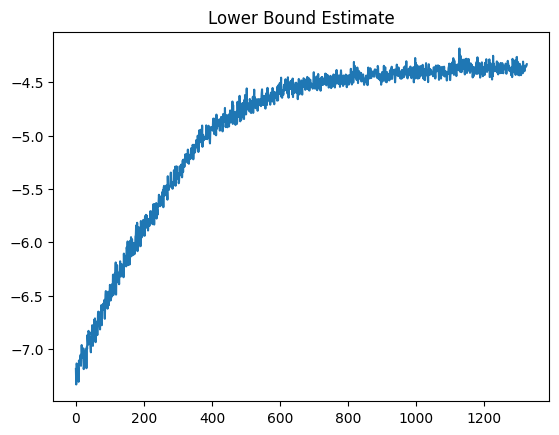

In [ ]:
import pandas as pd
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

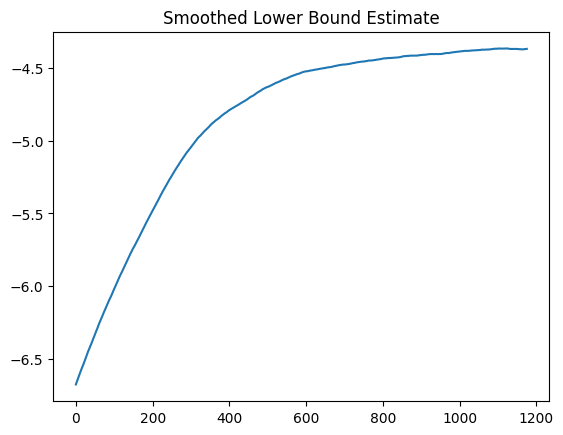

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_lambda_mu = np.array([0.56351477])
best_lambda_l = np.array([10.081537])

In [ ]:
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta)
posterior_mean_estimate

Array(0.56286156, dtype=float32)

Text(0.5, 1.0, 'Posterior density of theta')

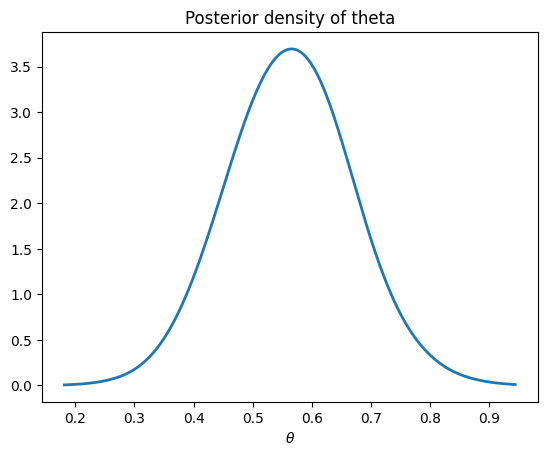

In [ ]:
from sklearn.neighbors import KernelDensity

plt.figure()
x_plot = jnp.arange((np.mean(best_theta)-4*np.std(best_theta)), (np.mean(best_theta)+4*np.std(best_theta)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_theta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\theta$')
plt.title('Posterior density of theta')

In [ ]:
best_lambda_mu = np.array([-0.2895302])
best_lambda_l = np.array([10.003352])

best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_rvbsl = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta_rvbsl)
posterior_mean_estimate

Array(-0.2901885, dtype=float32)

In [ ]:
best_lambda_mu = np.array([0.26250294])
best_lambda_l = np.array([10.763905])

best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_vbsl_wg = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta_vbsl_wg)
posterior_mean_estimate

Array(0.2618912, dtype=float32)

In [ ]:
best_lambda_mu = np.array([0.18864714])
best_lambda_l = np.array([10.016703])

best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_rvbsl_wg = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta_rvbsl_wg)
posterior_mean_estimate

Array(0.18798974, dtype=float32)

In [ ]:
theta_set = [best_theta, best_theta_rvbsl, best_theta_vbsl_wg, best_theta_rvbsl_wg]

Text(0.5, 1.0, 'Posterior density of theta')

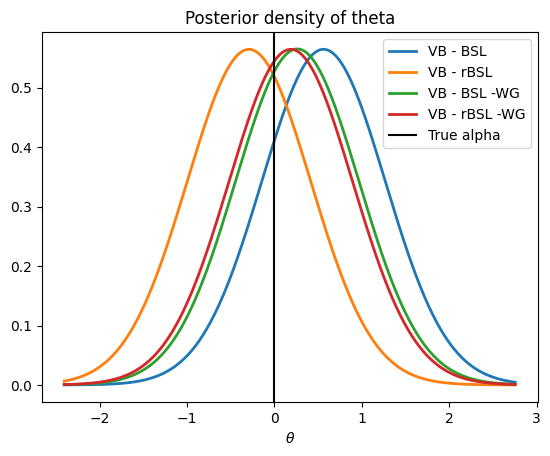

In [ ]:
plt.figure()
x_plot = np.arange(min(np.mean(theta_set[0])-27*np.std(theta_set[0]),np.mean(theta_set[3])-27*np.std(theta_set[3])), max(np.mean(theta_set[0])+23*np.std(theta_set[0]), np.mean(theta_set[3])+23*np.std(theta_set[3])), 0.002)

kde_vbsl = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde_vbsl.fit(theta_set[0].reshape(-1, 1))
y_plot_vbsl = kde_vbsl.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde_rvbsl.fit(theta_set[1].reshape(-1, 1))
y_plot_rvbsl = kde_rvbsl.score_samples(x_plot.reshape(-1, 1))

kde_vbsl_wg = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde_vbsl_wg.fit(theta_set[2].reshape(-1, 1))
y_plot_vbsl_wg = kde_vbsl_wg.score_samples(x_plot.reshape(-1, 1))

kde_rvbsl_wg = KernelDensity(bandwidth=0.7, kernel='gaussian')
kde_rvbsl_wg.fit(theta_set[3].reshape(-1, 1))
y_plot_rvbsl_wg = kde_rvbsl_wg.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vbsl), '-', linewidth=2.0, label = 'VB - BSL')
plt.plot(x_plot, np.exp(y_plot_rvbsl), '-', linewidth=2.0, label = 'VB - rBSL')
plt.plot(x_plot, np.exp(y_plot_vbsl_wg), '-', linewidth=2.0, label = 'VB - BSL -WG')
plt.plot(x_plot, np.exp(y_plot_rvbsl_wg), '-', linewidth=2.0, label = 'VB - rBSL -WG')
# only one line may be specified; full height
plt.axvline(x = 0, ymin = 0, color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\theta$')
plt.title('Posterior density of theta')